In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brain-tumor/LICENSE.txt
/kaggle/input/brain-tumor/brain-tumor.yaml
/kaggle/input/brain-tumor/labels/val/val_1 (131).txt
/kaggle/input/brain-tumor/labels/val/val_1 (203).txt
/kaggle/input/brain-tumor/labels/val/val_1 (86).txt
/kaggle/input/brain-tumor/labels/val/val_1 (201).txt
/kaggle/input/brain-tumor/labels/val/val_1 (11).txt
/kaggle/input/brain-tumor/labels/val/val_1 (113).txt
/kaggle/input/brain-tumor/labels/val/val_1 (209).txt
/kaggle/input/brain-tumor/labels/val/val_1 (43).txt
/kaggle/input/brain-tumor/labels/val/val_1 (145).txt
/kaggle/input/brain-tumor/labels/val/val_1 (22).txt
/kaggle/input/brain-tumor/labels/val/val_1 (133).txt
/kaggle/input/brain-tumor/labels/val/val_1 (111).txt
/kaggle/input/brain-tumor/labels/val/val_1 (92).txt
/kaggle/input/brain-tumor/labels/val/val_1 (149).txt
/kaggle/input/brain-tumor/labels/val/val_1 (103).txt
/kaggle/input/brain-tumor/labels/val/val_1 (21).txt
/kaggle/input/brain-tumor/labels/val/val_1 (134).txt
/kaggle/input/brain-tumo

In [40]:
import os
import cv2
import numpy as np
import pandas as pd
from glob import glob

# Paths
DATA_DIR = ""
IMG_TRAIN = os.path.join(DATA_DIR, "/kaggle/input/brain-tumor/images/train")
IMG_VAL = os.path.join(DATA_DIR, "/kaggle/input/brain-tumor/images/val")
LBL_TRAIN = os.path.join(DATA_DIR, "/kaggle/input/brain-tumor/labels/train")
LBL_VAL = os.path.join(DATA_DIR, "/kaggle/input/brain-tumor/labels/val")

# Function to read YOLO labels and crop ROI
def crop_roi(img_path, label_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    h, w = img.shape[:2]
    
    rois = []
    labels = []
    
    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f:
                cls, x, y, bw, bh = map(float, line.strip().split())
                # Convert YOLO format → pixel coordinates
                x, y, bw, bh = int(x * w), int(y * h), int(bw * w), int(bh * h)
                x1, y1 = max(0, x - bw // 2), max(0, y - bh // 2)
                x2, y2 = min(w, x + bw // 2), min(h, y + bh // 2)
                roi = img[y1:y2, x1:x2]
                rois.append(cv2.resize(roi, (128, 128)))
                labels.append(int(cls))  # 0=negative, 1=positive
    else:
        # No label file → assume negative
        rois.append(cv2.resize(img, (128, 128)))
        labels.append(0)
        
    return rois, labels

# Example: load one image & crop
sample_img = glob(os.path.join(IMG_TRAIN, "*.jpg"))[0]
sample_lbl = os.path.join(LBL_TRAIN, os.path.basename(sample_img).replace(".jpg", ".txt"))
rois, labs = crop_roi(sample_img, sample_lbl)
print("Sample ROI shape:", rois[0].shape, "Label:", labs[0])


Sample ROI shape: (128, 128) Label: 0


Train images found: 893


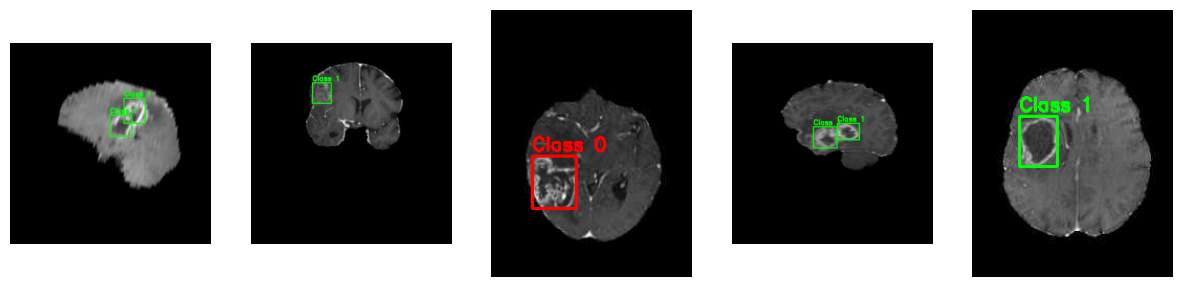

In [3]:
import os
import cv2
import matplotlib.pyplot as plt
import glob
import random

# Collect image paths (both jpg and png)
train_images = glob.glob(os.path.join(IMG_TRAIN, "*.jpg")) + glob.glob(os.path.join(IMG_TRAIN, "*.png"))

print("Train images found:", len(train_images))

# Function to plot image with bounding boxes
def show_image_with_labels(img_path, lbl_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # convert to RGB
    h, w = img.shape[:2]
    
    if os.path.exists(lbl_path):
        with open(lbl_path, "r") as f:
            for line in f:
                cls, x, y, bw, bh = map(float, line.strip().split())
                x, y, bw, bh = int(x * w), int(y * h), int(bw * w), int(bh * h)
                x1, y1 = max(0, x - bw // 2), max(0, y - bh // 2)
                x2, y2 = min(w, x + bw // 2), min(h, y + bh // 2)
                # draw rectangle
                color = (0, 255, 0) if int(cls) == 1 else (255, 0, 0)
                cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
                cv2.putText(img, f"Class {int(cls)}", (x1, y1 - 5),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
    return img

# Show 5 random images
plt.figure(figsize=(15, 10))
for i in range(5):
    img_path = random.choice(train_images)
    lbl_path = os.path.join(LBL_TRAIN, os.path.basename(img_path).replace(".jpg", ".txt").replace(".png", ".txt"))
    img = show_image_with_labels(img_path, lbl_path)
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.axis("off")
plt.show()


In [4]:
import cv2
import numpy as np
from glob import glob

# Preprocess a single ROI
def preprocess_roi(roi, size=(128,128), flatten=False):
    """
    roi: grayscale image cropped from YOLO labels
    size: desired output size
    flatten: if True, flatten to 1D vector
    """
    roi_resized = cv2.resize(roi, size)
    roi_norm = roi_resized.astype(np.float32) / 255.0  # normalize to 0-1
    if flatten:
        roi_norm = roi_norm.flatten()
    return roi_norm

# Load dataset and preprocess
def load_and_preprocess_dataset(img_dir, lbl_dir, size=(128,128), flatten=False):
    X, y = [], []
    for img_path in glob(img_dir + "/*.jpg"):
        lbl_path = lbl_dir + "/" + img_path.split("/")[-1].replace(".jpg",".txt")
        rois, labels = crop_roi(img_path, lbl_path)
        for roi, lab in zip(rois, labels):
            X.append(preprocess_roi(roi, size=size, flatten=flatten))
            y.append(lab)
    return np.array(X), np.array(y)

# Example usage for raw pixels (flattened) for Pipeline 1
X_raw_train, y_train = load_and_preprocess_dataset(IMG_TRAIN, LBL_TRAIN, size=(128,128), flatten=True)
X_raw_val, y_val = load_and_preprocess_dataset(IMG_VAL, LBL_VAL, size=(128,128), flatten=True)

# Example usage for CNN-ready input (2D)
X_cnn_train, _ = load_and_preprocess_dataset(IMG_TRAIN, LBL_TRAIN, size=(128,128), flatten=False)
X_cnn_val, _ = load_and_preprocess_dataset(IMG_VAL, LBL_VAL, size=(128,128), flatten=False)

print("Raw pixels train shape:", X_raw_train.shape)
print("CNN input train shape:", X_cnn_train.shape)
print("Labels train shape:", y_train.shape)


Raw pixels train shape: (940, 16384)
CNN input train shape: (940, 128, 128)
Labels train shape: (940,)


TRAIN: 0 images, 0 labels
VAL: 0 images, 0 labels

📊 Extracting Features ...
📂 Found 893 images in /kaggle/input/brain-tumor/images/train


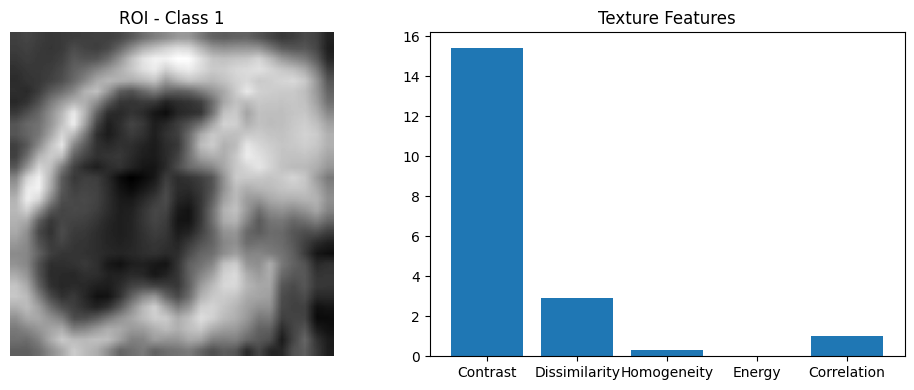

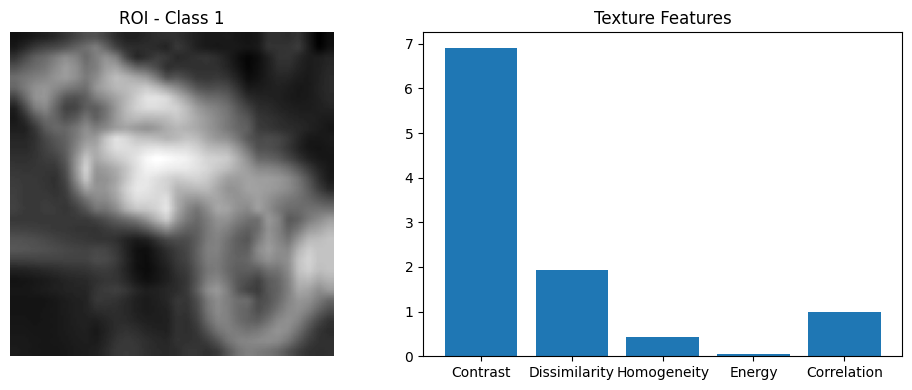

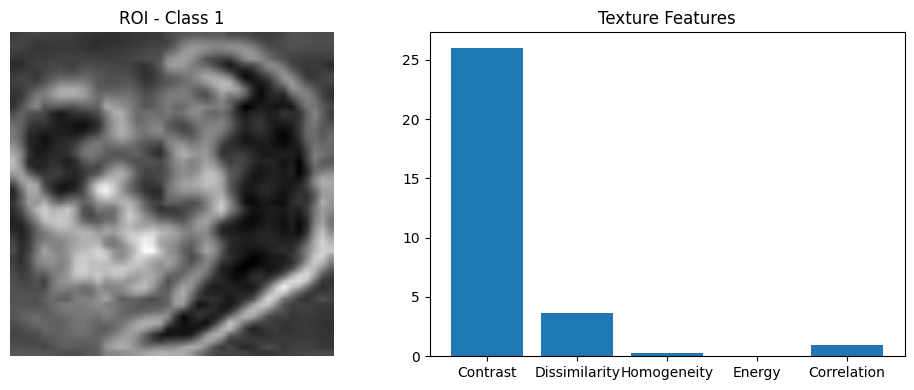

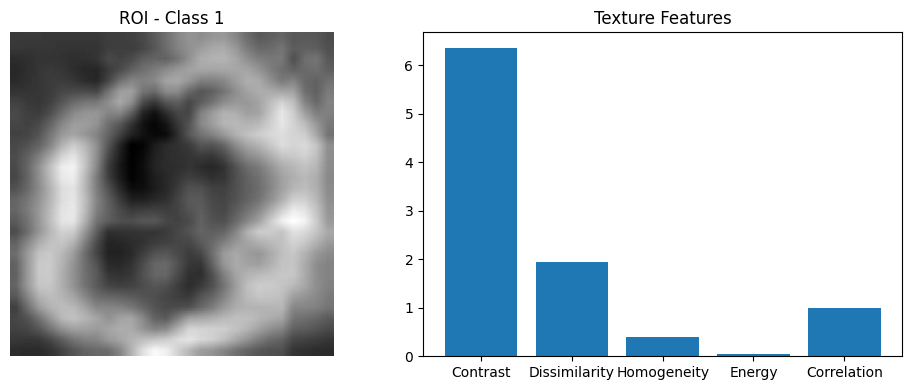

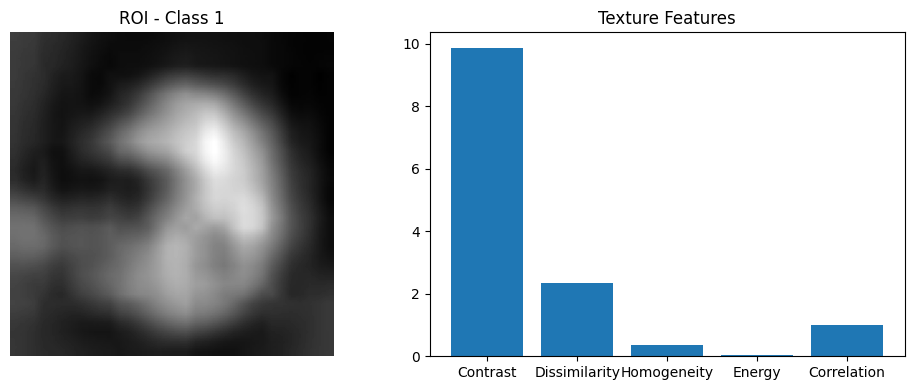

✅ Extracted 940 samples, feature length 16389
📂 Found 223 images in /kaggle/input/brain-tumor/images/val


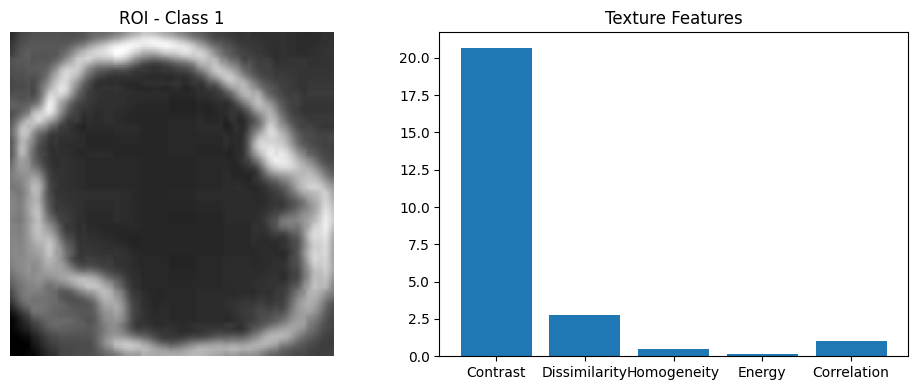

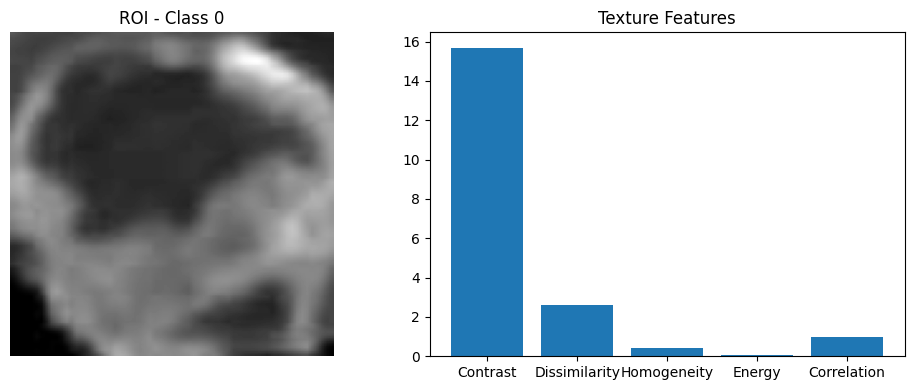

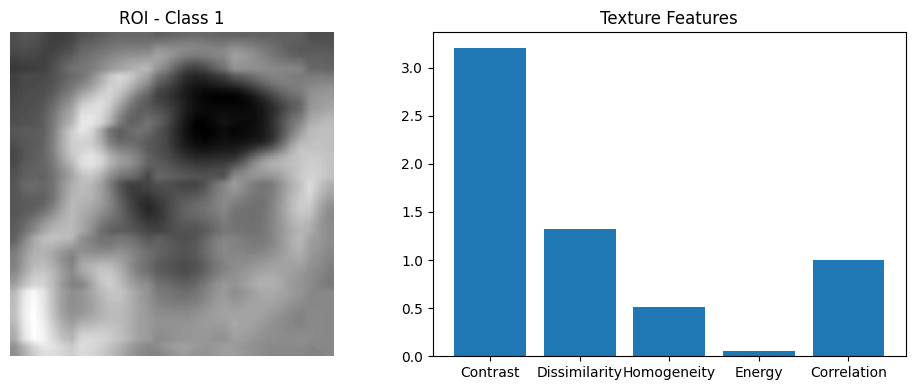

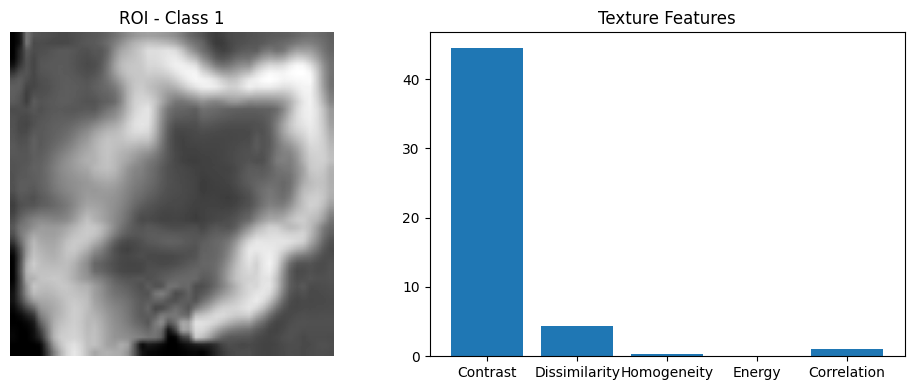

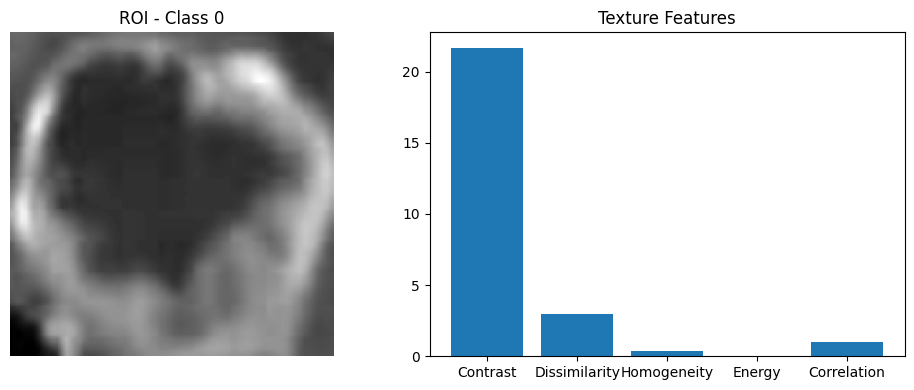

✅ Extracted 241 samples, feature length 16389

🤖 Training Model with Grid Search...


KeyboardInterrupt: 

In [7]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import graycomatrix, graycoprops
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import ParameterGrid
import pandas as pd
from glob import glob
import random

# ---------------------------
# 0️⃣ Paths (Update if needed)
# ---------------------------
DATA_DIR = ""  # <-- change if needed


# ---------------------------
# 🔍 Dataset Summary
# ---------------------------
def dataset_summary():
    for split in ["train", "val"]:
        img_dir = os.path.join(DATA_DIR, f"images/{split}")
        lbl_dir = os.path.join(DATA_DIR, f"labels/{split}")
        img_count = len(glob(os.path.join(img_dir, "*.jpg"))) + len(glob(os.path.join(img_dir, "*.png")))
        lbl_count = len(glob(os.path.join(lbl_dir, "*.txt")))
        print(f"{split.upper()}: {img_count} images, {lbl_count} labels")


dataset_summary()


# ---------------------------
# ROI Cropper
# ---------------------------
def crop_roi_with_boxes(img_path, label_path, show_boxes=False):
    img_color = cv2.imread(img_path)
    if img_color is None:
        print(f"⚠️ Could not read {img_path}")
        return [], [], [], None
    img_gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)
    h, w = img_gray.shape[:2]

    rois, labels, boxes = [], [], []

    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f:
                cls, x, y, bw, bh = map(float, line.strip().split())
                x, y, bw, bh = int(x * w), int(y * h), int(bw * w), int(bh * h)
                x1, y1 = max(0, x - bw // 2), max(0, y - bh // 2)
                x2, y2 = min(w, x + bw // 2), min(h, y + bh // 2)
                roi = img_gray[y1:y2, x1:x2]
                if roi.size == 0:
                    continue
                rois.append(cv2.resize(roi, (128, 128)))
                labels.append(int(cls))
                boxes.append((x1, y1, x2, y2))

                if show_boxes:
                    color = (0, 255, 0) if cls == 1 else (0, 0, 255)
                    cv2.rectangle(img_color, (x1, y1), (x2, y2), color, 2)
                    cv2.putText(img_color, f"Class: {int(cls)}", (x1, y1-10),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
    else:
        # no labels, treat whole image as negative
        rois.append(cv2.resize(img_gray, (128, 128)))
        labels.append(0)
        boxes.append((0, 0, w, h))
        if show_boxes:
            cv2.rectangle(img_color, (0, 0), (w, h), (0, 0, 255), 2)
            cv2.putText(img_color, "Class: 0", (5, 25),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

    return rois, labels, boxes, img_color


# ---------------------------
# GLCM Texture features
# ---------------------------
def extract_texture_features(roi):
    roi_uint8 = (roi * 255).astype(np.uint8)
    glcm = graycomatrix(roi_uint8, distances=[1], angles=[0],
                        levels=256, symmetric=True, normed=True)
    features = [
        graycoprops(glcm, 'contrast')[0, 0],
        graycoprops(glcm, 'dissimilarity')[0, 0],
        graycoprops(glcm, 'homogeneity')[0, 0],
        graycoprops(glcm, 'energy')[0, 0],
        graycoprops(glcm, 'correlation')[0, 0]
    ]
    return np.array(features)


# ---------------------------
# Preprocess & Extract Features
# ---------------------------
def preprocess_and_extract_features(img_dir, lbl_dir, visualize_features=5):
    X_features, y_labels = [], []
    img_paths = glob(os.path.join(img_dir, "*.jpg")) + glob(os.path.join(img_dir, "*.png"))
    print(f"📂 Found {len(img_paths)} images in {img_dir}")

    # Random sample for feature visualization
    feature_vis_samples = random.sample(img_paths, min(visualize_features, len(img_paths)))

    for img_path in img_paths:
        lbl_path = os.path.join(lbl_dir, os.path.basename(img_path).replace(".jpg", ".txt").replace(".png", ".txt"))
        rois, labels, boxes, _ = crop_roi_with_boxes(img_path, lbl_path, show_boxes=False)

        for idx, (roi, label) in enumerate(zip(rois, labels)):
            roi_norm = roi.astype(np.float32) / 255.0
            raw_pixels = roi_norm.flatten()
            texture_feats = extract_texture_features(roi_norm)
            final_features = np.concatenate([raw_pixels, texture_feats])

            X_features.append(final_features)
            y_labels.append(label)

            # Show feature visualization for few samples
            if img_path in feature_vis_samples and idx == 0:
                plt.figure(figsize=(10, 4))
                plt.subplot(1, 2, 1)
                plt.imshow(roi_norm, cmap='gray')
                plt.title(f"ROI - Class {label}")
                plt.axis('off')

                plt.subplot(1, 2, 2)
                plt.bar(['Contrast','Dissimilarity','Homogeneity','Energy','Correlation'], texture_feats)
                plt.title("Texture Features")
                plt.tight_layout()
                plt.show()

    X_features = np.array(X_features)
    y_labels = np.array(y_labels)
    print(f"✅ Extracted {X_features.shape[0]} samples, feature length {X_features.shape[1]}")
    return X_features, y_labels


# ---------------------------
# Random Forest Grid Search
# ---------------------------
def train_rf_gridsearch(X_train, y_train, X_val, y_val):
    param_grid = {
        "n_estimators": [50, 100, 200],
        "max_depth": [5, 10, 20, None],
        "min_samples_split": [2, 5, 10],
        "class_weight": [None, "balanced"]
    }

    grid = list(ParameterGrid(param_grid))
    results = []

    for i, params in enumerate(grid, 1):
        rf = RandomForestClassifier(random_state=42, **params)
        rf.fit(X_train, y_train)

        y_train_pred = rf.predict(X_train)
        y_val_pred = rf.predict(X_val)

        train_acc = accuracy_score(y_train, y_train_pred)
        val_acc = accuracy_score(y_val, y_val_pred)

        results.append({
            "params": params,
            "train_acc": train_acc,
            "val_acc": val_acc,
            "overfit_gap": train_acc - val_acc
        })

    results_df = pd.DataFrame(results).sort_values(by="val_acc", ascending=False).reset_index(drop=True)
    best_params = results_df.iloc[0]["params"]

    print("\n📊 Top Results by Validation Accuracy")
    print(results_df.head(10))

    # Train final model with best params
    best_rf = RandomForestClassifier(random_state=42, **best_params)
    best_rf.fit(X_train, y_train)

    y_val_pred = best_rf.predict(X_val)

    metrics = {
        "train_accuracy": accuracy_score(y_train, best_rf.predict(X_train)),
        "val_accuracy": accuracy_score(y_val, y_val_pred),
        "confusion_matrix": confusion_matrix(y_val, y_val_pred),
        "classification_report": classification_report(y_val, y_val_pred, output_dict=True)
    }

    return best_rf, metrics, y_val_pred


# ---------------------------
# Show Predictions on Images
# ---------------------------
def visualize_predictions(rf_model, img_dir, lbl_dir, num_samples=5):
    img_paths = glob(os.path.join(img_dir, "*.jpg")) + glob(os.path.join(img_dir, "*.png"))
    sample_paths = random.sample(img_paths, min(num_samples, len(img_paths)))

    for img_path in sample_paths:
        lbl_path = os.path.join(lbl_dir, os.path.basename(img_path).replace(".jpg", ".txt").replace(".png", ".txt"))
        rois, labels, boxes, img_color = crop_roi_with_boxes(img_path, lbl_path, show_boxes=False)

        for (roi, true_label, (x1, y1, x2, y2)) in zip(rois, labels, boxes):
            roi_norm = roi.astype(np.float32) / 255.0
            raw_pixels = roi_norm.flatten()
            texture_feats = extract_texture_features(roi_norm)
            features = np.concatenate([raw_pixels, texture_feats]).reshape(1, -1)

            pred_label = rf_model.predict(features)[0]
            color = (0, 255, 0) if pred_label == 1 else (0, 0, 255)
            cv2.rectangle(img_color, (x1, y1), (x2, y2), color, 2)
            cv2.putText(img_color, f"T:{true_label} P:{pred_label}", (x1, y1-10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

        plt.figure(figsize=(8, 6))
        plt.imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))
        plt.title(f"Predictions - {os.path.basename(img_path)}")
        plt.axis('off')
        plt.show()


# ---------------------------
# Main Execution
# ---------------------------
print("\n📊 Extracting Features ...")
X_train, y_train = preprocess_and_extract_features(IMG_TRAIN, LBL_TRAIN, visualize_features=5)
X_val, y_val = preprocess_and_extract_features(IMG_VAL, LBL_VAL, visualize_features=5)

if X_train.size > 0 and X_val.size > 0:
    print("\n🤖 Training Model with Grid Search...")
    rf_model, metrics, y_val_pred = train_rf_gridsearch(X_train, y_train, X_val, y_val)

    print("\n✅ Best Model Results")
    print("Training Accuracy:", metrics["train_accuracy"])
    print("Validation Accuracy:", metrics["val_accuracy"])
    print("Confusion Matrix:\n", metrics["confusion_matrix"])

    print("\n🎯 Visualizing Predictions on Validation Images")
    visualize_predictions(rf_model, IMG_VAL, LBL_VAL, num_samples=5)
else:
    print("❌ Not enough data to train model!")


TRAIN: 0 images, 0 labels
VAL: 0 images, 0 labels

📊 Extracting Features ...
📂 Found 893 images in /kaggle/input/brain-tumor/images/train


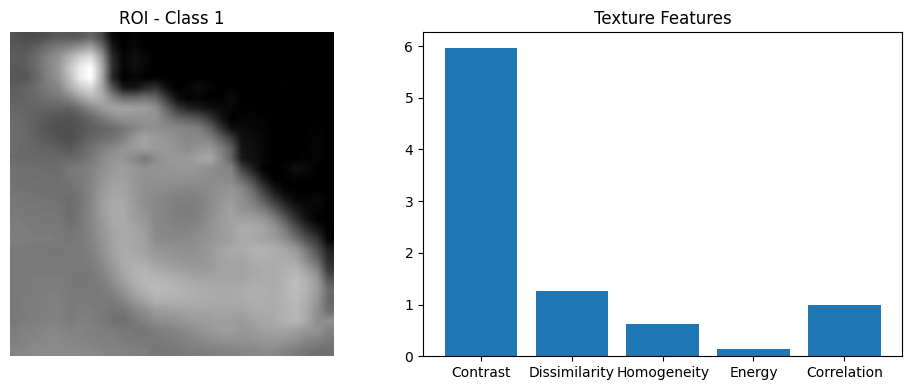

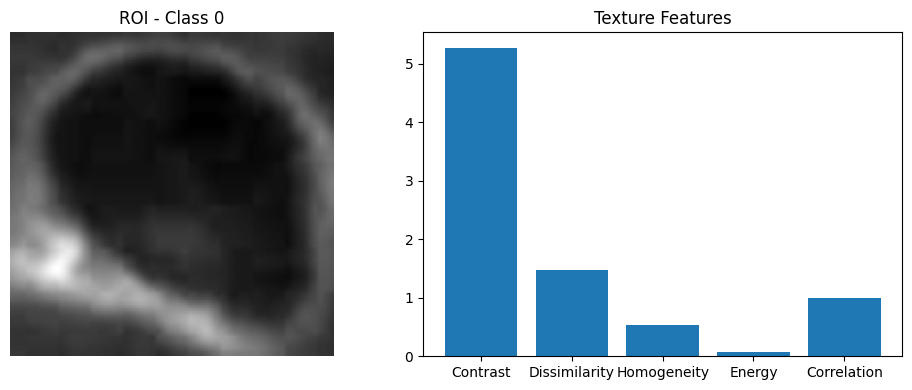

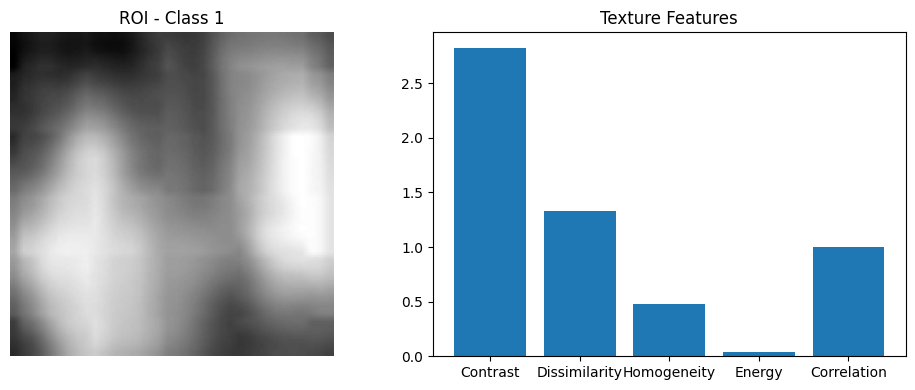

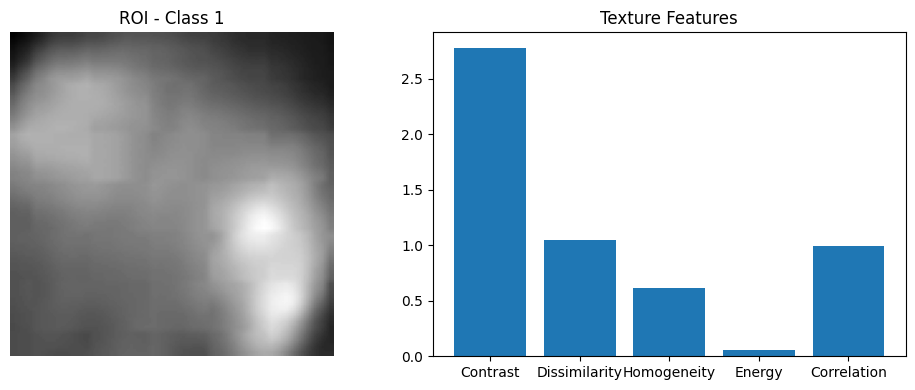

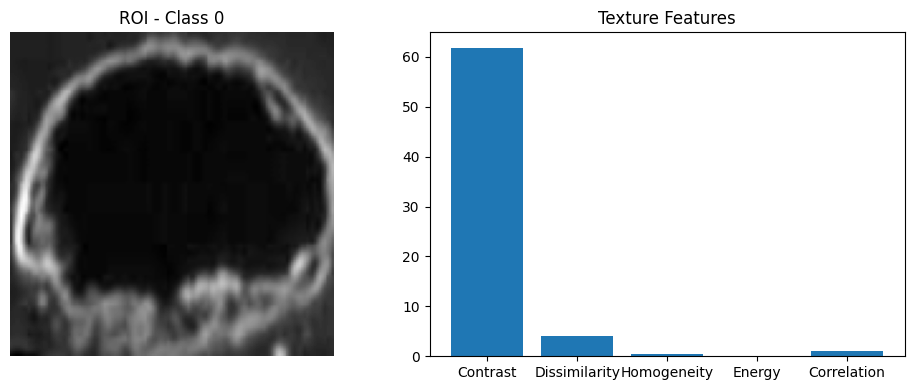

✅ Extracted 940 samples, feature length 16389
📂 Found 223 images in /kaggle/input/brain-tumor/images/val


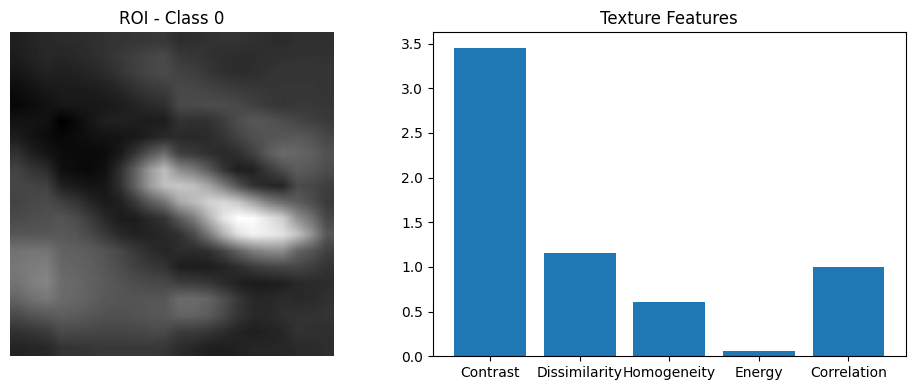

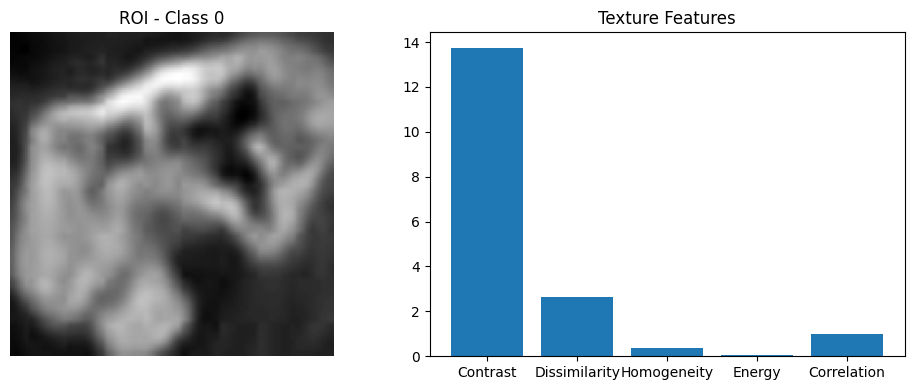

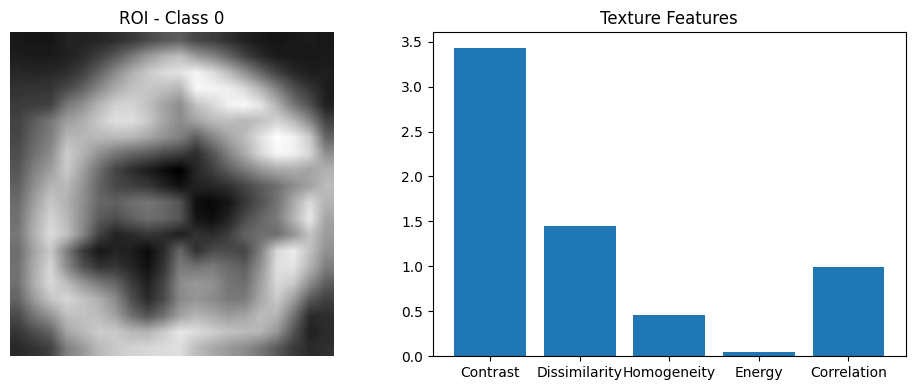

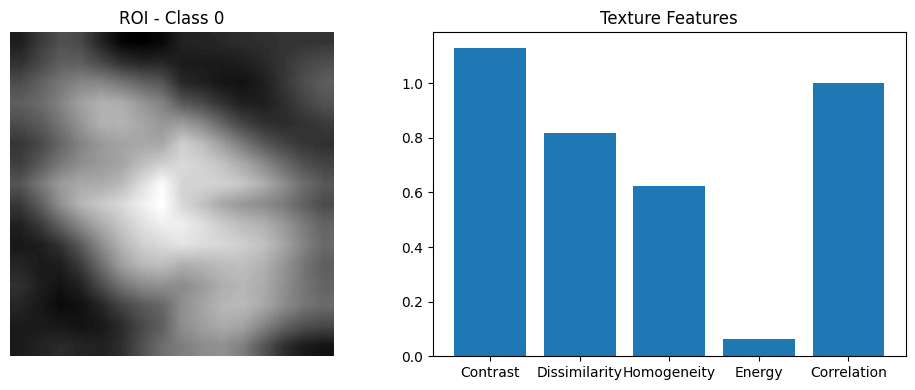

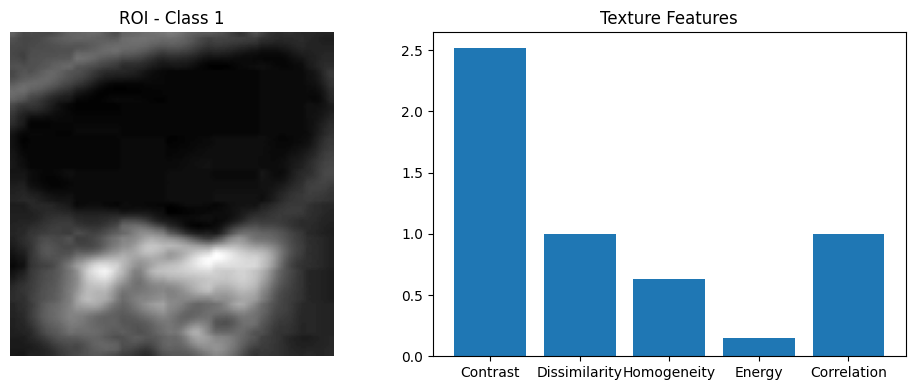

✅ Extracted 241 samples, feature length 16389

🤖 Training Model with Grid Search...

📊 Top Results by Validation Accuracy
                                              params  train_acc   val_acc  \
0  {'max_depth': 20, 'max_features': 'sqrt', 'n_e...   1.000000  0.522822   
1  {'max_depth': 20, 'max_features': 1.0, 'n_esti...   1.000000  0.522822   
2  {'max_depth': 10, 'max_features': 1.0, 'n_esti...   1.000000  0.522822   
3  {'max_depth': 10, 'max_features': 'sqrt', 'n_e...   0.996809  0.518672   
4  {'max_depth': 20, 'max_features': 1.0, 'n_esti...   1.000000  0.514523   

   overfit_gap  
0     0.477178  
1     0.477178  
2     0.477178  
3     0.478136  
4     0.485477  


/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:368: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)



✅ Best Model Results
Training Accuracy: 1.0
Validation Accuracy: 0.5228216052055359
Confusion Matrix:
 [[61 93]
 [22 65]]

🎯 Visualizing Predictions on Validation Images


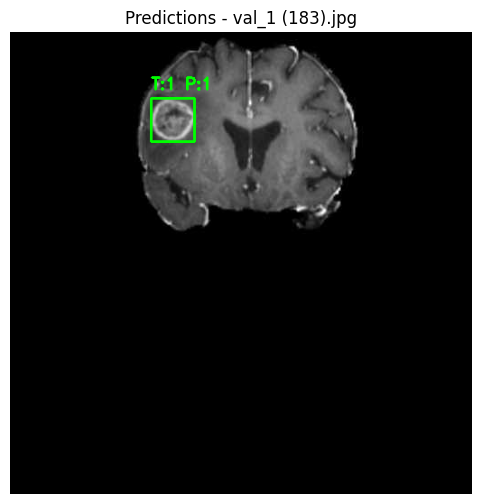

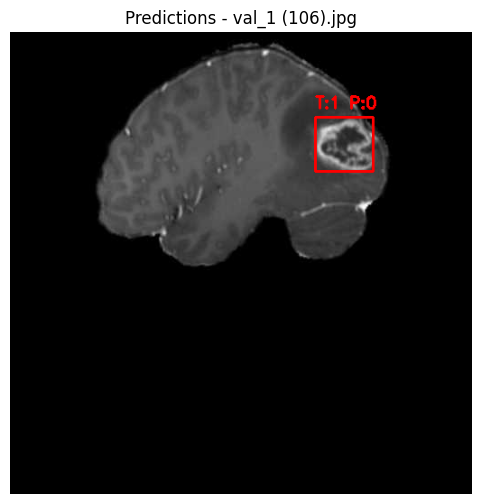

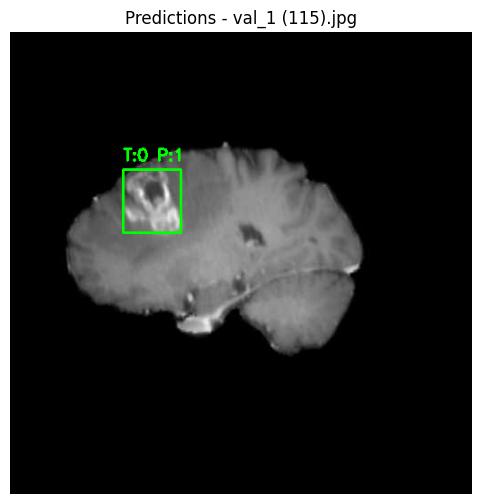

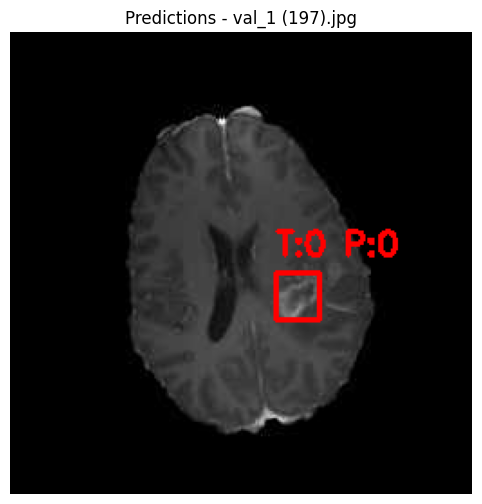

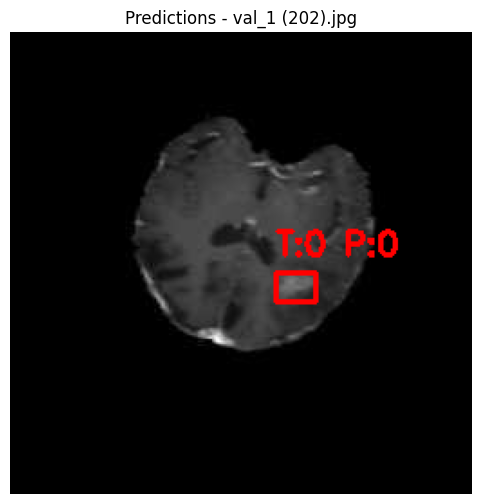

In [11]:
import os
import cv2
import cupy as cp   # GPU-based numpy
import numpy as np  # still needed for skimage
import matplotlib.pyplot as plt
from skimage.feature import graycomatrix, graycoprops
from cuml.ensemble import RandomForestClassifier  # GPU RandomForest
from cuml.metrics import accuracy_score           # GPU accuracy
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import ParameterGrid
import pandas as pd
from glob import glob
import random

# ---------------------------
# 0️⃣ Paths (Update if needed)
# ---------------------------
DATA_DIR = ""  # <-- change if needed


# ---------------------------
# 🔍 Dataset Summary
# ---------------------------
def dataset_summary():
    for split in ["train", "val"]:
        img_dir = os.path.join(DATA_DIR, f"images/{split}")
        lbl_dir = os.path.join(DATA_DIR, f"labels/{split}")
        img_count = len(glob(os.path.join(img_dir, "*.jpg"))) + len(glob(os.path.join(img_dir, "*.png")))
        lbl_count = len(glob(os.path.join(lbl_dir, "*.txt")))
        print(f"{split.upper()}: {img_count} images, {lbl_count} labels")


dataset_summary()


# ---------------------------
# ROI Cropper
# ---------------------------
def crop_roi_with_boxes(img_path, label_path, show_boxes=False):
    img_color = cv2.imread(img_path)
    if img_color is None:
        print(f"⚠️ Could not read {img_path}")
        return [], [], [], None
    img_gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)
    h, w = img_gray.shape[:2]

    rois, labels, boxes = [], [], []

    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f:
                cls, x, y, bw, bh = map(float, line.strip().split())
                x, y, bw, bh = int(x * w), int(y * h), int(bw * w), int(bh * h)
                x1, y1 = max(0, x - bw // 2), max(0, y - bh // 2)
                x2, y2 = min(w, x + bw // 2), min(h, y + bh // 2)
                roi = img_gray[y1:y2, x1:x2]
                if roi.size == 0:
                    continue
                rois.append(cv2.resize(roi, (128, 128)))
                labels.append(int(cls))
                boxes.append((x1, y1, x2, y2))

                if show_boxes:
                    color = (0, 255, 0) if cls == 1 else (0, 0, 255)
                    cv2.rectangle(img_color, (x1, y1), (x2, y2), color, 2)
                    cv2.putText(img_color, f"Class: {int(cls)}", (x1, y1-10),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
    else:
        # no labels, treat whole image as negative
        rois.append(cv2.resize(img_gray, (128, 128)))
        labels.append(0)
        boxes.append((0, 0, w, h))
        if show_boxes:
            cv2.rectangle(img_color, (0, 0), (w, h), (0, 0, 255), 2)
            cv2.putText(img_color, "Class: 0", (5, 25),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

    return rois, labels, boxes, img_color


# ---------------------------
# GLCM Texture features (CPU)
# ---------------------------
def extract_texture_features(roi):
    roi_uint8 = (roi * 255).astype(np.uint8)
    glcm = graycomatrix(roi_uint8, distances=[1], angles=[0],
                        levels=256, symmetric=True, normed=True)
    features = [
        graycoprops(glcm, 'contrast')[0, 0],
        graycoprops(glcm, 'dissimilarity')[0, 0],
        graycoprops(glcm, 'homogeneity')[0, 0],
        graycoprops(glcm, 'energy')[0, 0],
        graycoprops(glcm, 'correlation')[0, 0]
    ]
    return np.array(features, dtype=np.float32)


# ---------------------------
# Preprocess & Extract Features (GPU arrays)
# ---------------------------
def preprocess_and_extract_features(img_dir, lbl_dir, visualize_features=5):
    X_features, y_labels = [], []
    img_paths = glob(os.path.join(img_dir, "*.jpg")) + glob(os.path.join(img_dir, "*.png"))
    print(f"📂 Found {len(img_paths)} images in {img_dir}")

    # Random sample for feature visualization
    feature_vis_samples = random.sample(img_paths, min(visualize_features, len(img_paths)))

    for img_path in img_paths:
        lbl_path = os.path.join(lbl_dir, os.path.basename(img_path).replace(".jpg", ".txt").replace(".png", ".txt"))
        rois, labels, boxes, _ = crop_roi_with_boxes(img_path, lbl_path, show_boxes=False)

        for idx, (roi, label) in enumerate(zip(rois, labels)):
            # send ROI to GPU
            roi_norm = cp.asarray(roi.astype(cp.float32)) / 255.0
            raw_pixels = roi_norm.flatten()

            # texture features still CPU → move back & forth
            texture_feats = extract_texture_features(cp.asnumpy(roi_norm))
            texture_feats_gpu = cp.asarray(texture_feats)

            final_features = cp.concatenate([raw_pixels, texture_feats_gpu])

            X_features.append(final_features)
            y_labels.append(label)

            # Show feature visualization for few samples
            if img_path in feature_vis_samples and idx == 0:
                plt.figure(figsize=(10, 4))
                plt.subplot(1, 2, 1)
                plt.imshow(cp.asnumpy(roi_norm), cmap='gray')
                plt.title(f"ROI - Class {label}")
                plt.axis('off')

                plt.subplot(1, 2, 2)
                plt.bar(['Contrast','Dissimilarity','Homogeneity','Energy','Correlation'],
                        cp.asnumpy(texture_feats_gpu))
                plt.title("Texture Features")
                plt.tight_layout()
                plt.show()

    X_features = cp.asarray(X_features)
    y_labels = cp.asarray(y_labels)
    print(f"✅ Extracted {X_features.shape[0]} samples, feature length {X_features.shape[1]}")
    return X_features, y_labels


# ---------------------------
# Random Forest Grid Search (GPU)
# ---------------------------
def train_rf_gridsearch(X_train, y_train, X_val, y_val):
    # ✅ smaller param grid for speed
    param_grid = {
        "n_estimators": [50, 100],          # fewer values
        "max_depth": [5, 10, 20],           # must be >0 in cuML
        "max_features": ["sqrt", 1.0],      # auto → sqrt
    }

    grid = list(ParameterGrid(param_grid))
    results = []

    for i, params in enumerate(grid, 1):
        rf = RandomForestClassifier(random_state=42, **params)
        rf.fit(X_train, y_train)

        y_train_pred = rf.predict(X_train)
        y_val_pred = rf.predict(X_val)

        train_acc = float(accuracy_score(y_train, y_train_pred))
        val_acc = float(accuracy_score(y_val, y_val_pred))

        results.append({
            "params": params,
            "train_acc": train_acc,
            "val_acc": val_acc,
            "overfit_gap": train_acc - val_acc
        })

    results_df = pd.DataFrame(results).sort_values(by="val_acc", ascending=False).reset_index(drop=True)
    best_params = results_df.iloc[0]["params"]

    print("\n📊 Top Results by Validation Accuracy")
    print(results_df.head(5))

    # Train final model with best params
    best_rf = RandomForestClassifier(random_state=42, **best_params)
    best_rf.fit(X_train, y_train)

    y_val_pred = best_rf.predict(X_val)

    metrics = {
        "train_accuracy": float(accuracy_score(y_train, best_rf.predict(X_train))),
        "val_accuracy": float(accuracy_score(y_val, y_val_pred)),
        "confusion_matrix": confusion_matrix(cp.asnumpy(y_val), cp.asnumpy(y_val_pred)),
        "classification_report": classification_report(cp.asnumpy(y_val), cp.asnumpy(y_val_pred), output_dict=True)
    }

    return best_rf, metrics, y_val_pred



# ---------------------------
# Show Predictions on Images
# ---------------------------
def visualize_predictions(rf_model, img_dir, lbl_dir, num_samples=5):
    img_paths = glob(os.path.join(img_dir, "*.jpg")) + glob(os.path.join(img_dir, "*.png"))
    sample_paths = random.sample(img_paths, min(num_samples, len(img_paths)))

    for img_path in sample_paths:
        lbl_path = os.path.join(lbl_dir, os.path.basename(img_path).replace(".jpg", ".txt").replace(".png", ".txt"))
        rois, labels, boxes, img_color = crop_roi_with_boxes(img_path, lbl_path, show_boxes=False)

        for (roi, true_label, (x1, y1, x2, y2)) in zip(rois, labels, boxes):
            roi_norm = cp.asarray(roi.astype(cp.float32)) / 255.0
            raw_pixels = roi_norm.flatten()
            texture_feats = extract_texture_features(cp.asnumpy(roi_norm))
            features = cp.concatenate([raw_pixels, cp.asarray(texture_feats)]).reshape(1, -1)

            pred_label = int(rf_model.predict(features)[0])
            color = (0, 255, 0) if pred_label == 1 else (0, 0, 255)
            cv2.rectangle(img_color, (x1, y1), (x2, y2), color, 2)
            cv2.putText(img_color, f"T:{true_label} P:{pred_label}", (x1, y1-10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

        plt.figure(figsize=(8, 6))
        plt.imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))
        plt.title(f"Predictions - {os.path.basename(img_path)}")
        plt.axis('off')
        plt.show()


# ---------------------------
# Main Execution
# ---------------------------
print("\n📊 Extracting Features ...")
X_train, y_train = preprocess_and_extract_features(IMG_TRAIN, LBL_TRAIN, visualize_features=5)
X_val, y_val = preprocess_and_extract_features(IMG_VAL, LBL_VAL, visualize_features=5)

if X_train.size > 0 and X_val.size > 0:
    print("\n🤖 Training Model with Grid Search...")
    rf_model, metrics, y_val_pred = train_rf_gridsearch(X_train, y_train, X_val, y_val)

    print("\n✅ Best Model Results")
    print("Training Accuracy:", metrics["train_accuracy"])
    print("Validation Accuracy:", metrics["val_accuracy"])
    print("Confusion Matrix:\n", metrics["confusion_matrix"])

    print("\n🎯 Visualizing Predictions on Validation Images")
    visualize_predictions(rf_model, IMG_VAL, LBL_VAL, num_samples=5)
else:
    print("❌ Not enough data to train model!")



🎯 Visualizing Predictions vs Actual


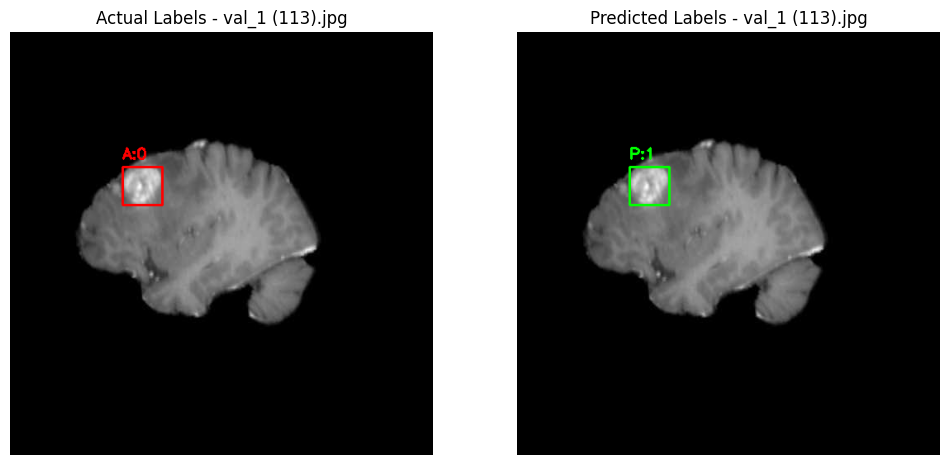

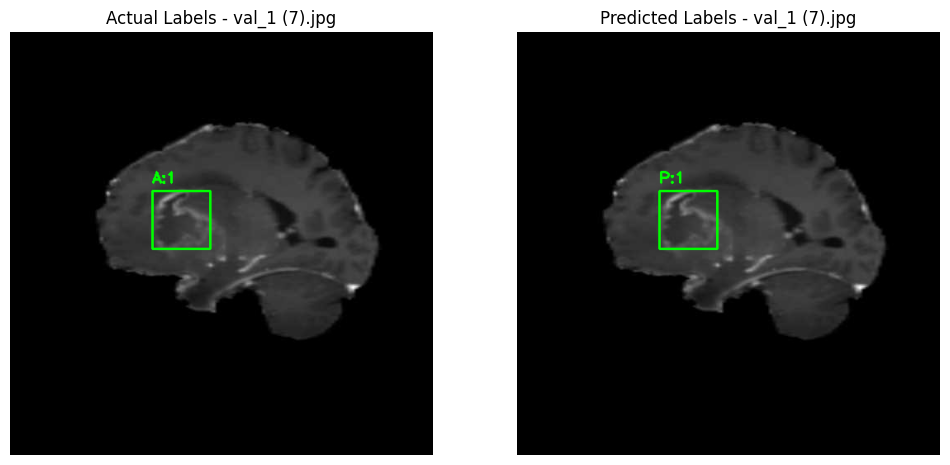

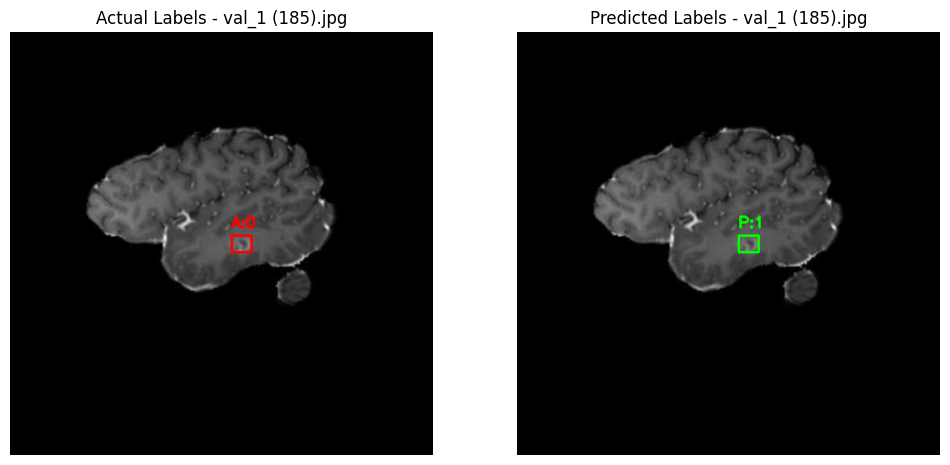

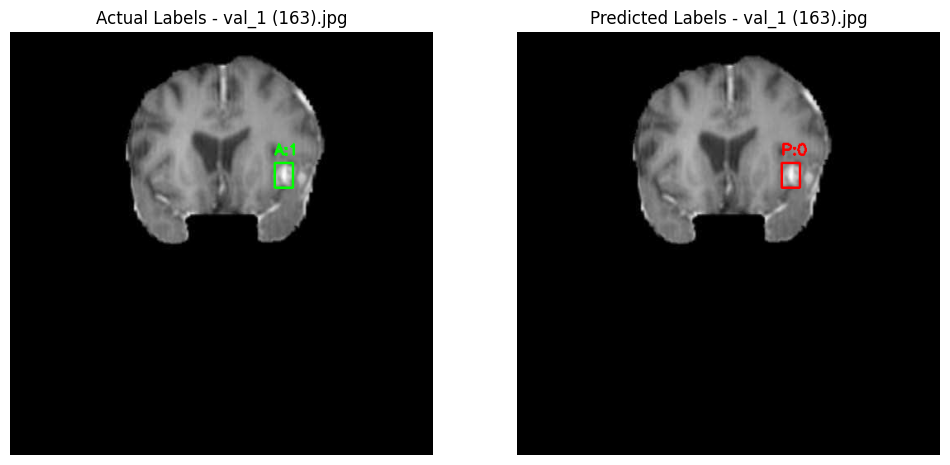

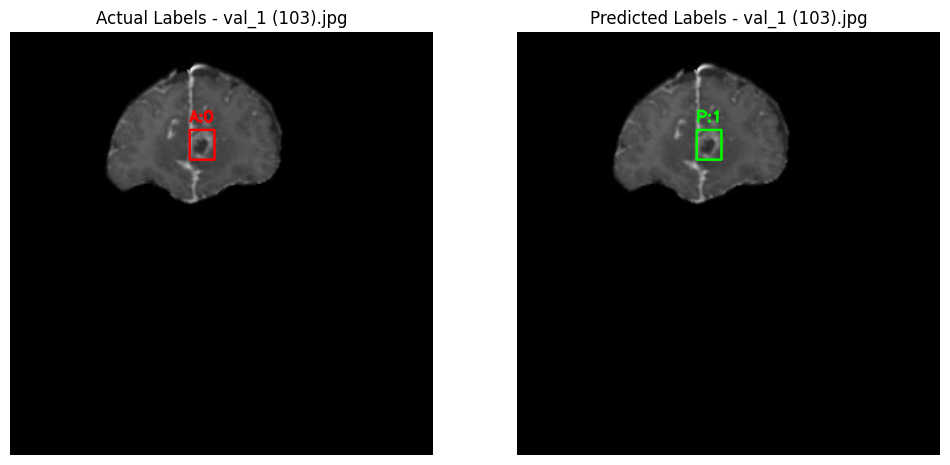

In [13]:
# ---------------------------
# Show Predictions vs Actual
# ---------------------------
def visualize_predictions_vs_actual(rf_model, img_dir, lbl_dir, num_samples=5):
    img_paths = glob(os.path.join("/kaggle/input/brain-tumor/images/val", "*.jpg")) + glob(os.path.join("/kaggle/input/brain-tumor/images/val", "*.png"))
    sample_paths = random.sample(img_paths, min(num_samples, len(img_paths)))

    for img_path in sample_paths:
        lbl_path = os.path.join(lbl_dir, os.path.basename(img_path).replace(".jpg", ".txt").replace(".png", ".txt"))
        rois, labels, boxes, img_color = crop_roi_with_boxes(img_path, lbl_path, show_boxes=False)

        if len(rois) == 0:
            continue

        # --- Copy image for actual & predicted views ---
        img_actual = img_color.copy()
        img_pred = img_color.copy()

        for (roi, true_label, (x1, y1, x2, y2)) in zip(rois, labels, boxes):
            roi_norm = roi.astype(np.float32) / 255.0
            raw_pixels = roi_norm.flatten()
            texture_feats = extract_texture_features(roi_norm)
            features = np.concatenate([raw_pixels, texture_feats]).reshape(1, -1)

            pred_label = rf_model.predict(features)[0]

            # Draw actual labels
            color_actual = (0, 255, 0) if true_label == 1 else (0, 0, 255)
            cv2.rectangle(img_actual, (x1, y1), (x2, y2), color_actual, 2)
            cv2.putText(img_actual, f"A:{true_label}", (x1, y1-10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, color_actual, 2)

            # Draw predicted labels
            color_pred = (0, 255, 0) if pred_label == 1 else (0, 0, 255)
            cv2.rectangle(img_pred, (x1, y1), (x2, y2), color_pred, 2)
            cv2.putText(img_pred, f"P:{pred_label}", (x1, y1-10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, color_pred, 2)

        # --- Plot side by side ---
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(img_actual, cv2.COLOR_BGR2RGB))
        plt.title(f"Actual Labels - {os.path.basename(img_path)}")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(img_pred, cv2.COLOR_BGR2RGB))
        plt.title(f"Predicted Labels - {os.path.basename(img_path)}")
        plt.axis('off')

        plt.show()
print("\n🎯 Visualizing Predictions vs Actual")
visualize_predictions_vs_actual(rf_model, IMG_VAL, LBL_VAL, num_samples=5)



📊 Extracting HOG + Texture Features ...
📂 Found 893 images in /kaggle/input/brain-tumor/images/train


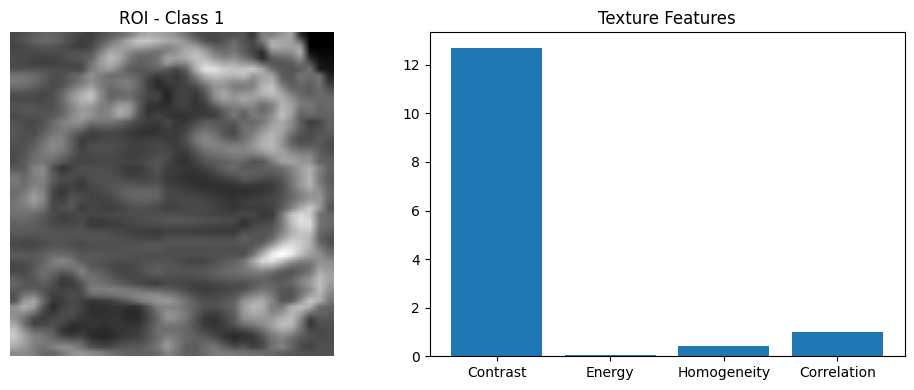

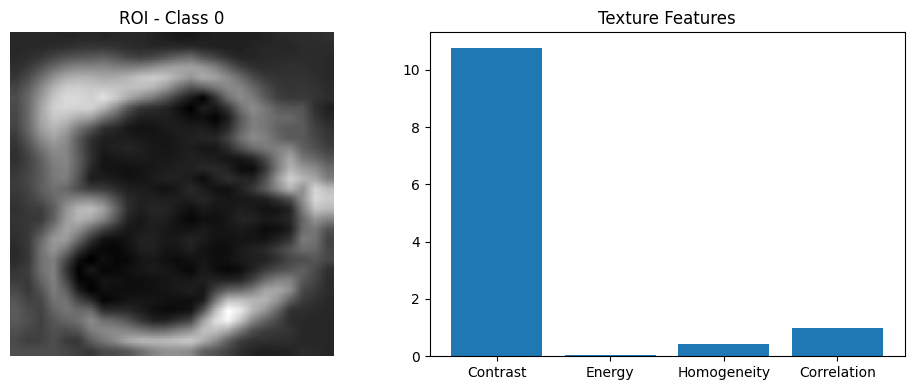

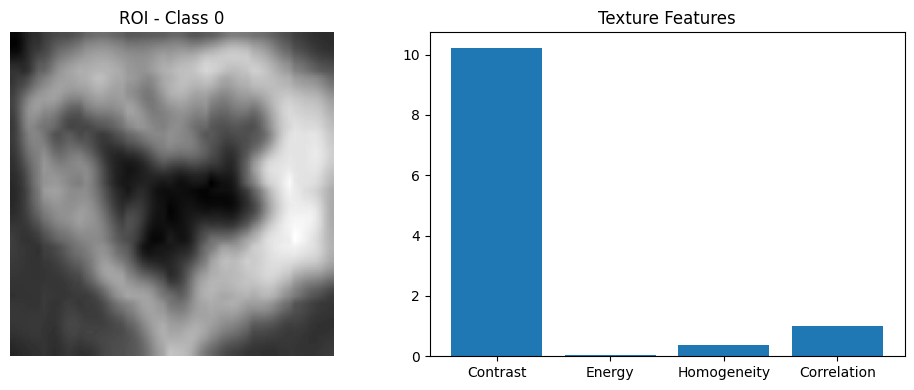

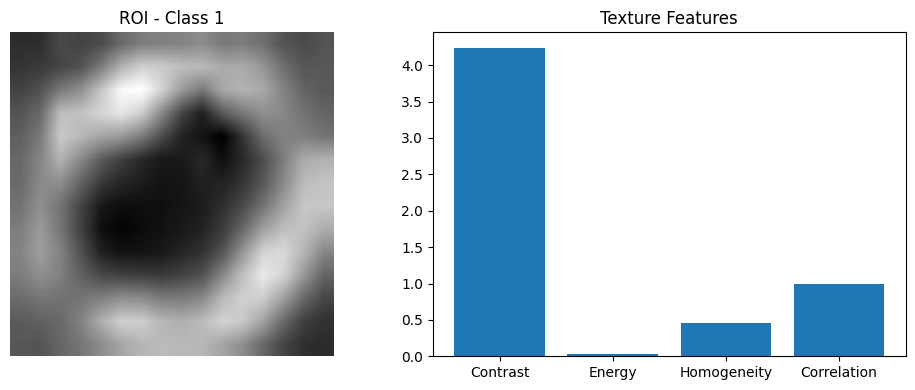

Exception ignored in: <cyfunction RandomForestClassifier.__del__ at 0x7f8cd11cedc0>
Traceback (most recent call last):
  File "randomforestclassifier.pyx", line 352, in cuml.ensemble.randomforestclassifier.RandomForestClassifier.__del__
  File "randomforestclassifier.pyx", line 356, in cuml.ensemble.randomforestclassifier.RandomForestClassifier._reset_forest_data
  File "base.pyx", line 889, in cuml.internals.base.UniversalBase.__getattr__
  File "base.pyx", line 858, in cuml.internals.base.UniversalBase.__getattr__
  File "base.pyx", line 398, in cuml.internals.base.Base.__getattr__
AttributeError: rf_forest


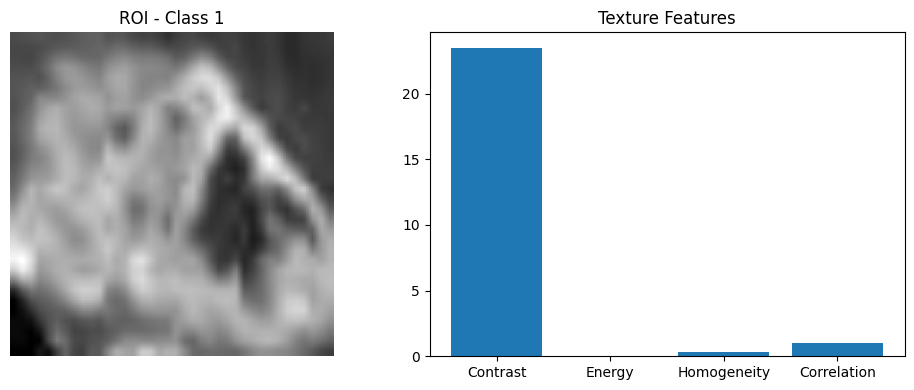

✅ Extracted 940 samples, feature length 8104
📂 Found 223 images in /kaggle/input/brain-tumor/images/val


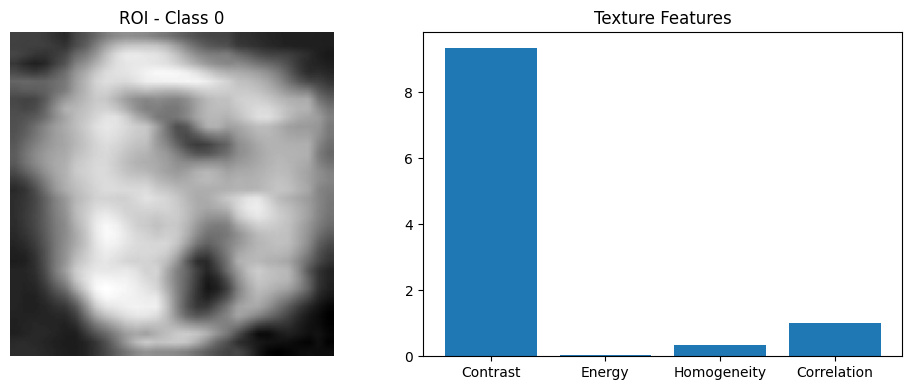

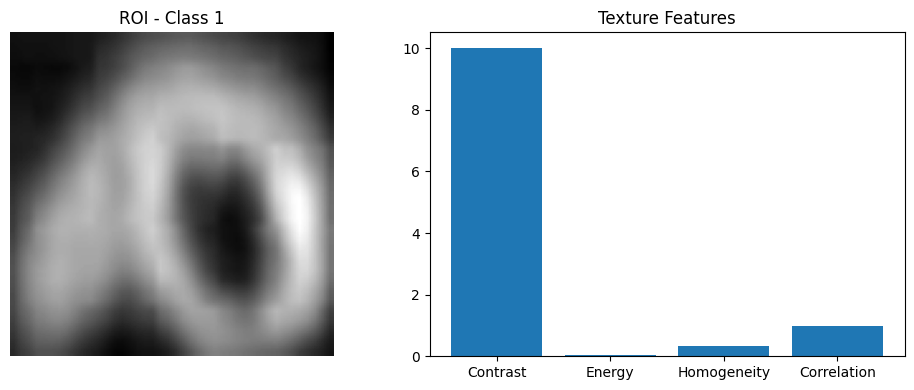

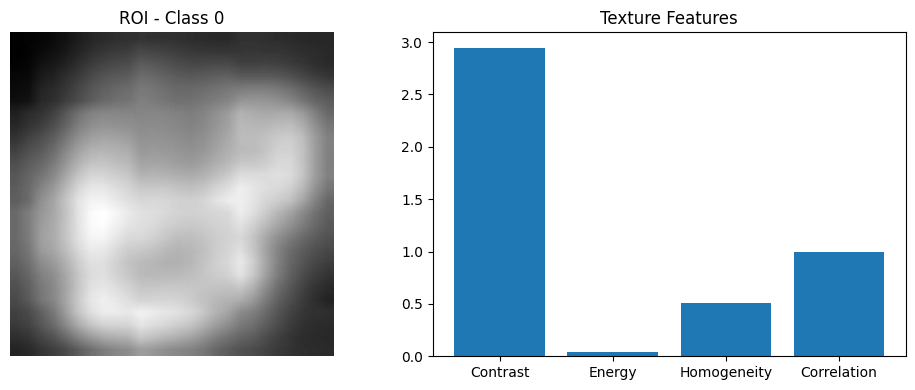

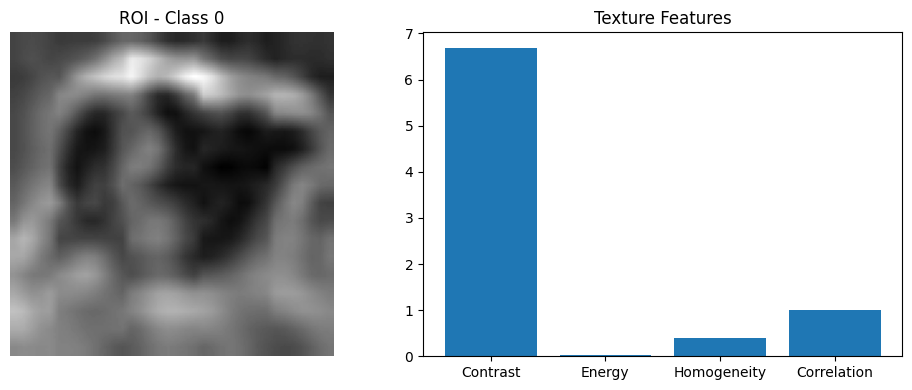

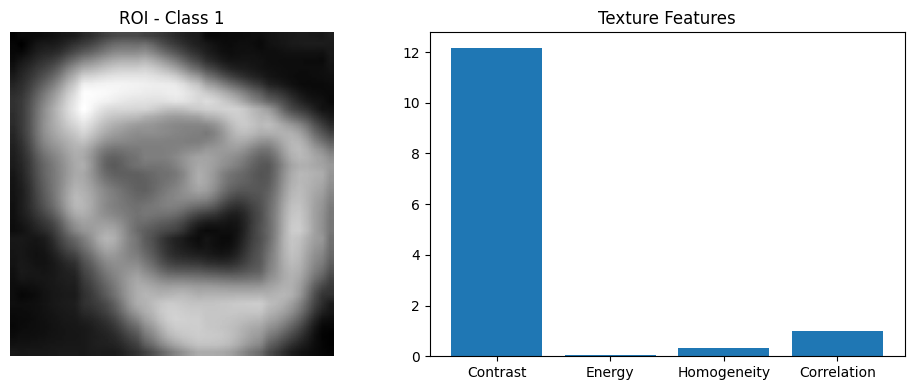

✅ Extracted 241 samples, feature length 8104

🤖 Training GPU SVM with Grid Search...

📊 Top Results by Validation Accuracy
                                         params  train_acc   val_acc  \
0  {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}   1.000000  0.506224   
1   {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}   0.753191  0.460581   
2   {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}   0.784043  0.456432   
3    {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}   0.535106  0.360996   
4  {'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}   0.521277  0.356846   

   overfit_gap  
0     0.493776  
1     0.292611  
2     0.327611  
3     0.174111  
4     0.164430  

✅ Best Model Results
Training Accuracy: 1.0
Validation Accuracy: 0.5062240663900415
Confusion Matrix:
 [[80 74]
 [45 42]]


In [16]:
import os
import cv2
import cupy as cp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from glob import glob
from cuml.svm import SVC
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from skimage.feature import hog, graycomatrix, graycoprops

# ---------------------------
# ROI Cropper (same as before)
# ---------------------------
def crop_roi_with_boxes(img_path, label_path, show_boxes=False):
    img_color = cv2.imread(img_path)
    if img_color is None:
        print(f"⚠️ Could not read {img_path}")
        return [], [], [], None
    img_gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)
    h, w = img_gray.shape[:2]

    rois, labels, boxes = [], [], []

    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f:
                cls, x, y, bw, bh = map(float, line.strip().split())
                x, y, bw, bh = int(x * w), int(y * h), int(bw * w), int(bh * h)
                x1, y1 = max(0, x - bw // 2), max(0, y - bh // 2)
                x2, y2 = min(w, x + bw // 2), min(h, y + bh // 2)
                roi = img_gray[y1:y2, x1:x2]
                if roi.size == 0:
                    continue
                rois.append(cv2.resize(roi, (128, 128)))
                labels.append(int(cls))
                boxes.append((x1, y1, x2, y2))
    else:
        rois.append(cv2.resize(img_gray, (128, 128)))
        labels.append(0)
        boxes.append((0, 0, w, h))

    return rois, labels, boxes, img_color


# ---------------------------
# Texture features (GLCM)
# ---------------------------
def extract_texture_features(roi):
    roi_uint8 = (roi * 255).astype(np.uint8)
    glcm = graycomatrix(roi_uint8, distances=[1], angles=[0],
                        levels=256, symmetric=True, normed=True)
    features = [
        graycoprops(glcm, 'contrast')[0, 0],
        graycoprops(glcm, 'energy')[0, 0],
        graycoprops(glcm, 'homogeneity')[0, 0],
        graycoprops(glcm, 'correlation')[0, 0]
    ]
    return np.array(features)


# ---------------------------
# Preprocess & Extract Features (HOG + Texture)
# ---------------------------
def preprocess_and_extract_features(img_dir, lbl_dir, visualize_features=5):
    X_features, y_labels = [], []
    img_paths = glob(os.path.join(img_dir, "*.jpg")) + glob(os.path.join(img_dir, "*.png"))
    print(f"📂 Found {len(img_paths)} images in {img_dir}")

    feature_vis_samples = random.sample(img_paths, min(visualize_features, len(img_paths)))

    for img_path in img_paths:
        lbl_path = os.path.join(lbl_dir, os.path.basename(img_path).replace(".jpg", ".txt").replace(".png", ".txt"))
        rois, labels, boxes, _ = crop_roi_with_boxes(img_path, lbl_path, show_boxes=False)

        for idx, (roi, label) in enumerate(zip(rois, labels)):
            roi_norm = roi.astype(np.float32) / 255.0

            # 🔹 HOG Features
            hog_feats = hog(roi_norm, pixels_per_cell=(8, 8),
                            cells_per_block=(2, 2), orientations=9,
                            block_norm='L2-Hys', feature_vector=True)

            # 🔹 Texture Features
            texture_feats = extract_texture_features(roi_norm)

            # 🔹 Combine
            final_features = np.concatenate([hog_feats, texture_feats])

            X_features.append(final_features)
            y_labels.append(label)

            # Visualize a few
            if img_path in feature_vis_samples and idx == 0:
                plt.figure(figsize=(10, 4))
                plt.subplot(1, 2, 1)
                plt.imshow(roi_norm, cmap='gray')
                plt.title(f"ROI - Class {label}")
                plt.axis('off')

                plt.subplot(1, 2, 2)
                plt.bar(['Contrast','Energy','Homogeneity','Correlation'], texture_feats)
                plt.title("Texture Features")
                plt.tight_layout()
                plt.show()

    X_features = cp.asarray(X_features)  # move to GPU
    y_labels = cp.asarray(y_labels)
    print(f"✅ Extracted {X_features.shape[0]} samples, feature length {X_features.shape[1]}")
    return X_features, y_labels


# ---------------------------
# SVM (GPU) Grid Search
# ---------------------------
def train_svm_gridsearch(X_train, y_train, X_val, y_val):
    param_grid = {
        "C": [0.1, 1, 10],
        "kernel": ["rbf"],
        "gamma": ["scale", "auto"]
    }

    grid = list(ParameterGrid(param_grid))
    results = []

    for params in grid:
        svm = SVC(**params)
        svm.fit(X_train, y_train)

        y_train_pred = svm.predict(X_train)
        y_val_pred = svm.predict(X_val)

        train_acc = float(accuracy_score(cp.asnumpy(y_train), cp.asnumpy(y_train_pred)))
        val_acc = float(accuracy_score(cp.asnumpy(y_val), cp.asnumpy(y_val_pred)))

        results.append({
            "params": params,
            "train_acc": train_acc,
            "val_acc": val_acc,
            "overfit_gap": train_acc - val_acc
        })

    results_df = pd.DataFrame(results).sort_values(by="val_acc", ascending=False).reset_index(drop=True)
    best_params = results_df.iloc[0]["params"]

    print("\n📊 Top Results by Validation Accuracy")
    print(results_df.head(5))

    best_svm = SVC(**best_params)
    best_svm.fit(X_train, y_train)
    y_val_pred = best_svm.predict(X_val)

    metrics = {
        "train_accuracy": float(accuracy_score(cp.asnumpy(y_train), cp.asnumpy(best_svm.predict(X_train)))),
        "val_accuracy": float(accuracy_score(cp.asnumpy(y_val), cp.asnumpy(y_val_pred))),
        "confusion_matrix": confusion_matrix(cp.asnumpy(y_val), cp.asnumpy(y_val_pred)),
        "classification_report": classification_report(cp.asnumpy(y_val), cp.asnumpy(y_val_pred), output_dict=True)
    }

    return best_svm, metrics, y_val_pred


# ---------------------------
# MAIN EXECUTION
# ---------------------------
print("\n📊 Extracting HOG + Texture Features ...")
X_train, y_train = preprocess_and_extract_features(IMG_TRAIN, LBL_TRAIN, visualize_features=5)
X_val, y_val = preprocess_and_extract_features(IMG_VAL, LBL_VAL, visualize_features=5)

if X_train.size > 0 and X_val.size > 0:
    print("\n🤖 Training GPU SVM with Grid Search...")
    svm_model, metrics, y_val_pred = train_svm_gridsearch(X_train, y_train, X_val, y_val)

    print("\n✅ Best Model Results")
    print("Training Accuracy:", metrics["train_accuracy"])
    print("Validation Accuracy:", metrics["val_accuracy"])
    print("Confusion Matrix:\n", metrics["confusion_matrix"])
else:
    print("❌ Not enough data to train model!")


📊 PCA Visualization of Training Features


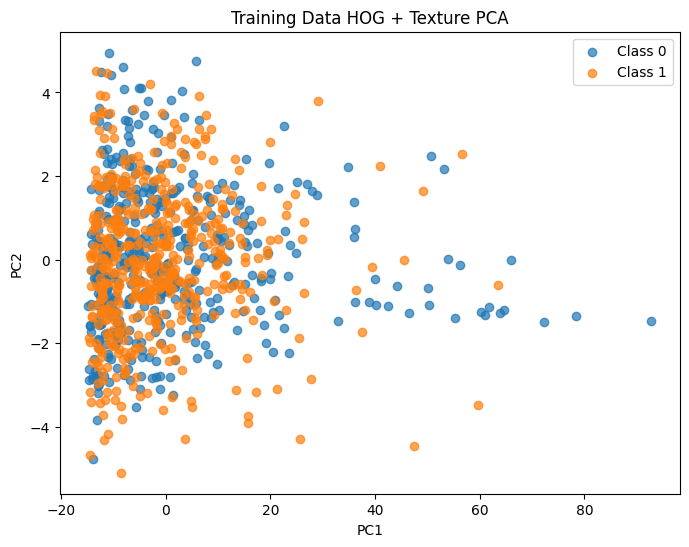

Explained variance ratio (PC1, PC2): [0.63273038 0.00915551]
📊 PCA Visualization of Validation Features


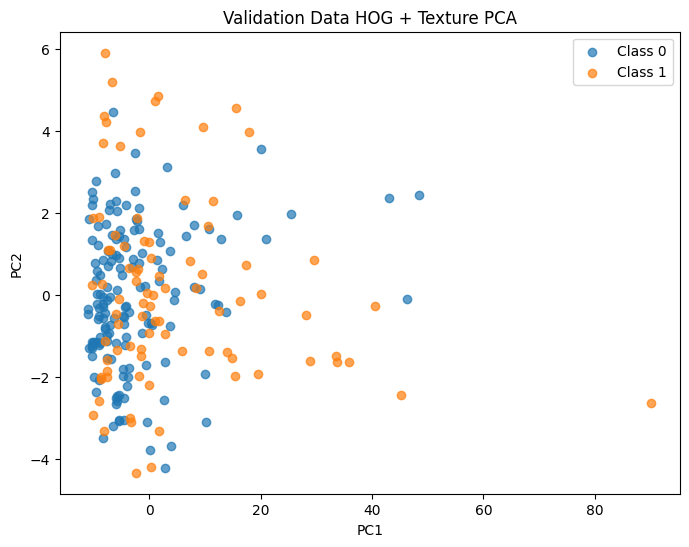

Explained variance ratio (PC1, PC2): [0.572799   0.01342185]


In [18]:
from cuml.decomposition import PCA
import matplotlib.pyplot as plt

def plot_pca_2d(X, y, title="PCA 2D Projection"):
    """
    X : cp.array (n_samples, n_features)
    y : cp.array (n_samples,)
    """
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)  # (n_samples, 2)

    X_pca_cpu = cp.asnumpy(X_pca)
    y_cpu = cp.asnumpy(y)

    plt.figure(figsize=(8,6))
    for label in np.unique(y_cpu):
        plt.scatter(
            X_pca_cpu[y_cpu==label, 0],
            X_pca_cpu[y_cpu==label, 1],
            label=f"Class {label}",
            alpha=0.7
        )

    plt.title(title)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()
    plt.show()

    # Variance explained
    print("Explained variance ratio (PC1, PC2):", pca.explained_variance_ratio_)

# After feature extraction
print("📊 PCA Visualization of Training Features")
plot_pca_2d(X_train, y_train, title="Training Data HOG + Texture PCA")

print("📊 PCA Visualization of Validation Features")
plot_pca_2d(X_val, y_val, title="Validation Data HOG + Texture PCA")



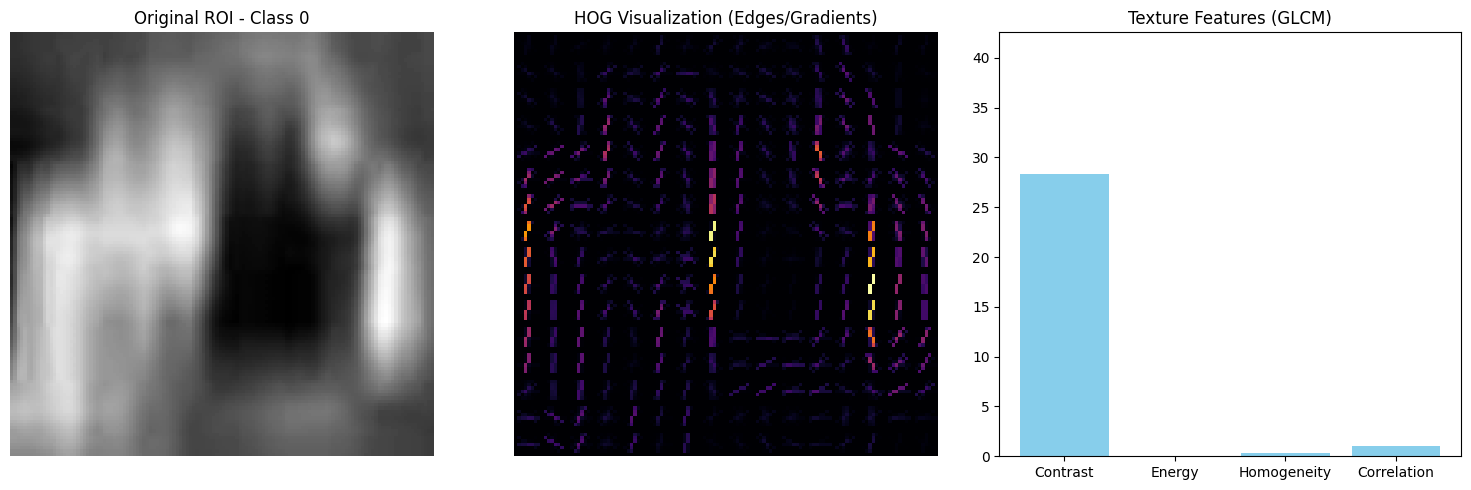

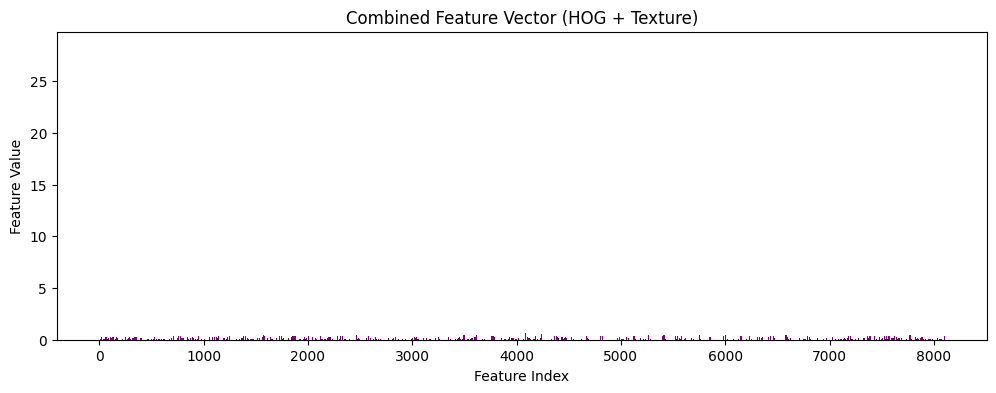

HOG feature length: 8100
Texture feature length: 4
Combined feature length: 8104
Texture values: Contrast=28.371, Energy=0.028, Homogeneity=0.349, Correlation=0.993


In [25]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import hog, graycomatrix, graycoprops
import cv2

# ---------------------------
# Pick one ROI for demonstration
# ---------------------------
# Example: first image from training folder
example_img_path = glob(os.path.join(IMG_TRAIN, "*.jpg"))[0]
example_lbl_path = os.path.join(LBL_TRAIN, os.path.basename(example_img_path).replace(".jpg", ".txt"))

rois, labels, boxes, _ = crop_roi_with_boxes(example_img_path, example_lbl_path)
roi = rois[0]  # pick first ROI
label = labels[0]

roi_norm = roi.astype(np.float32)/255.0

# ---------------------------
# HOG Features + Visualization
# ---------------------------
hog_feats, hog_image = hog(
    roi_norm,
    orientations=9,
    pixels_per_cell=(8,8),
    cells_per_block=(2,2),
    block_norm='L2-Hys',
    visualize=True,
    feature_vector=True
)

# ---------------------------
# Texture Features
# ---------------------------
roi_uint8 = (roi_norm*255).astype(np.uint8)
glcm = graycomatrix(roi_uint8, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
texture_feats = [
    graycoprops(glcm, 'contrast')[0,0],
    graycoprops(glcm, 'energy')[0,0],
    graycoprops(glcm, 'homogeneity')[0,0],
    graycoprops(glcm, 'correlation')[0,0]
]

# ---------------------------
# Visualization
# ---------------------------
fig, axes = plt.subplots(1,3, figsize=(15,5))

# Original ROI
axes[0].imshow(roi_norm, cmap='gray')
axes[0].set_title(f"Original ROI - Class {label}")
axes[0].axis('off')

# HOG edges
axes[1].imshow(hog_image, cmap='inferno')
axes[1].set_title("HOG Visualization (Edges/Gradients)")
axes[1].axis('off')

# Texture features
axes[2].bar(['Contrast','Energy','Homogeneity','Correlation'], texture_feats, color='skyblue')
axes[2].set_title("Texture Features (GLCM)")
axes[2].set_ylim(0, max(texture_feats)*1.5)

plt.tight_layout()
plt.show()

# ---------------------------
# Optional: Combined Feature Histogram
# ---------------------------
combined_features = np.hstack([hog_feats, texture_feats])
plt.figure(figsize=(12,4))
plt.bar(range(len(combined_features)), combined_features, color='purple')
plt.title("Combined Feature Vector (HOG + Texture)")
plt.xlabel("Feature Index")
plt.ylabel("Feature Value")
plt.show()

print(f"HOG feature length: {len(hog_feats)}")
print(f"Texture feature length: {len(texture_feats)}")
print(f"Combined feature length: {len(combined_features)}")
print(f"Texture values: Contrast={texture_feats[0]:.3f}, Energy={texture_feats[1]:.3f}, Homogeneity={texture_feats[2]:.3f}, Correlation={texture_feats[3]:.3f}")


📂 Found 893 images in /kaggle/input/brain-tumor/images/train


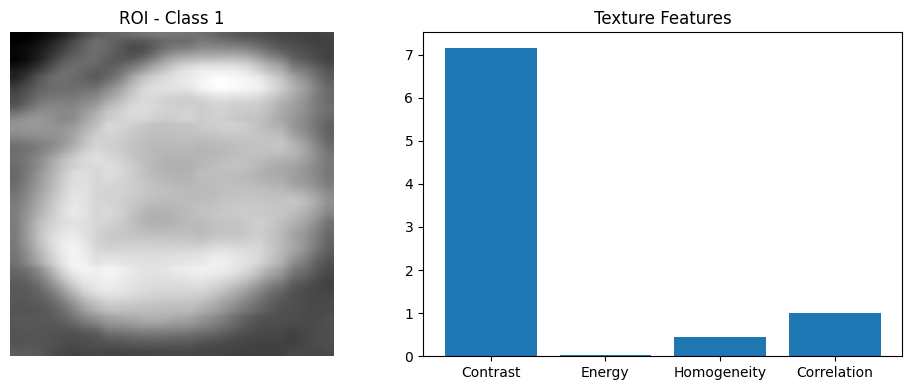

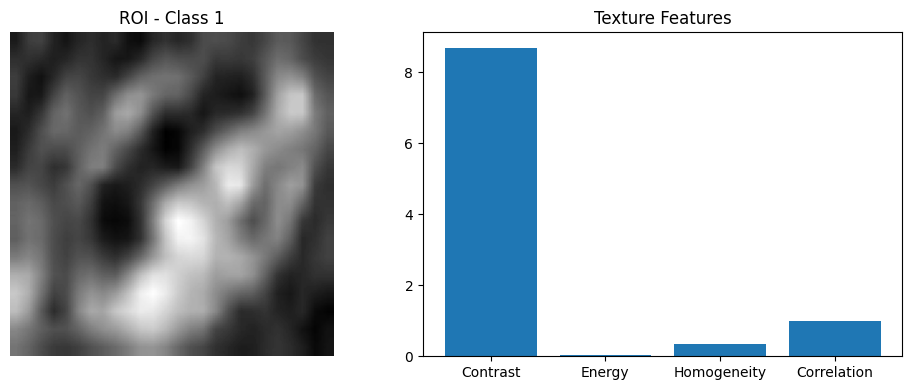

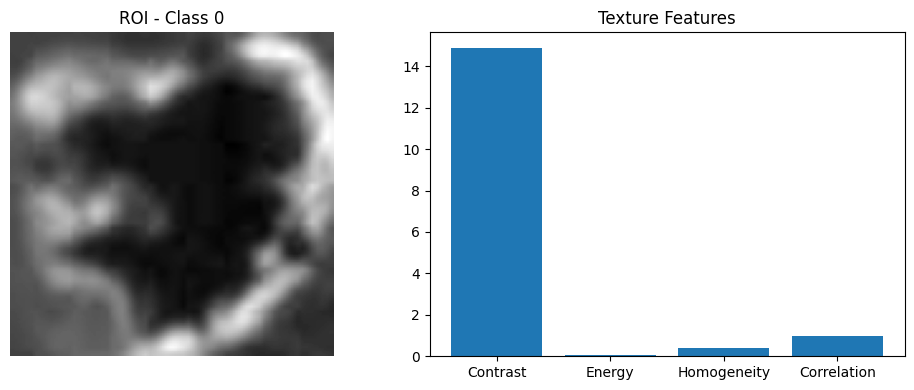

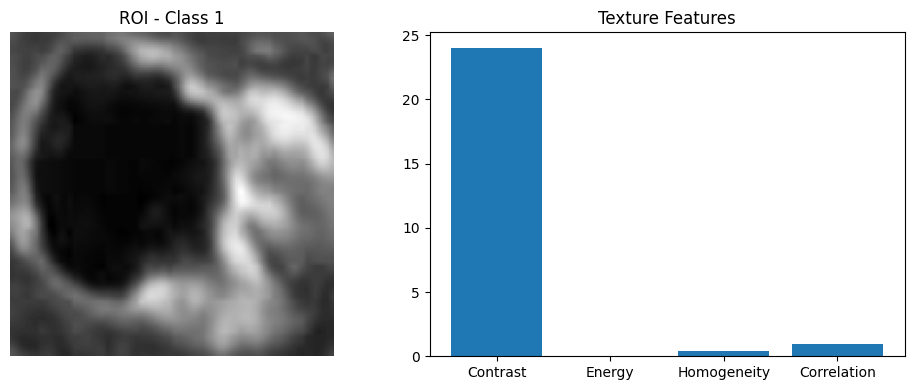

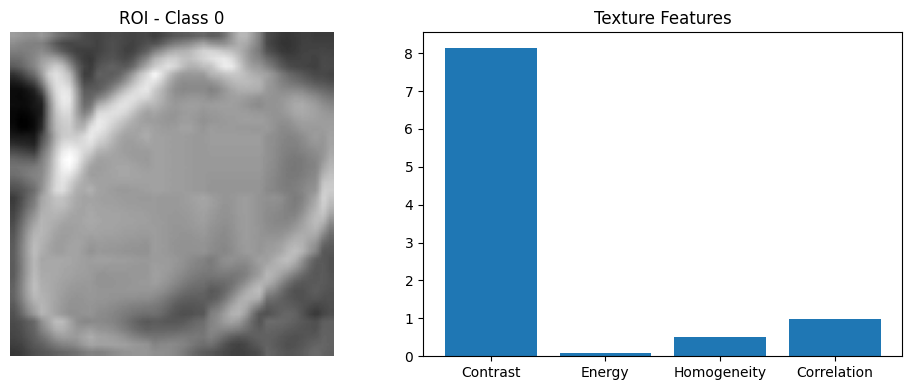

✅ Extracted 940 samples, feature length 8104
📂 Found 223 images in /kaggle/input/brain-tumor/images/val


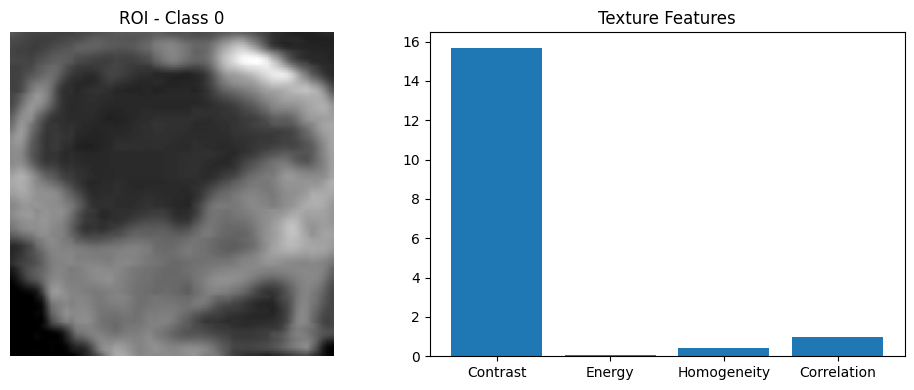

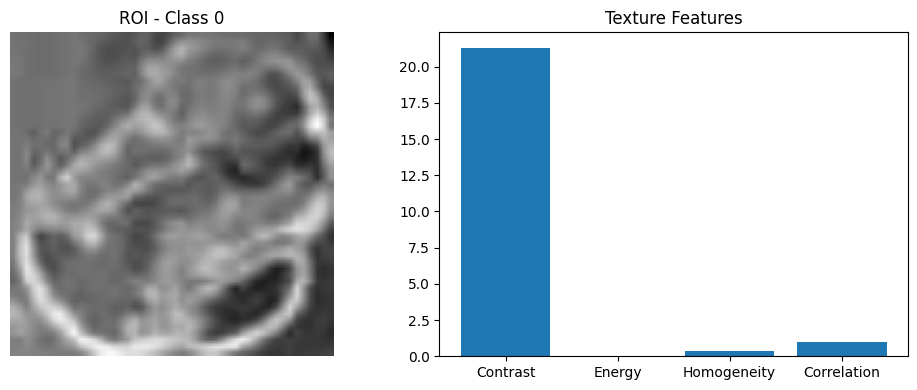

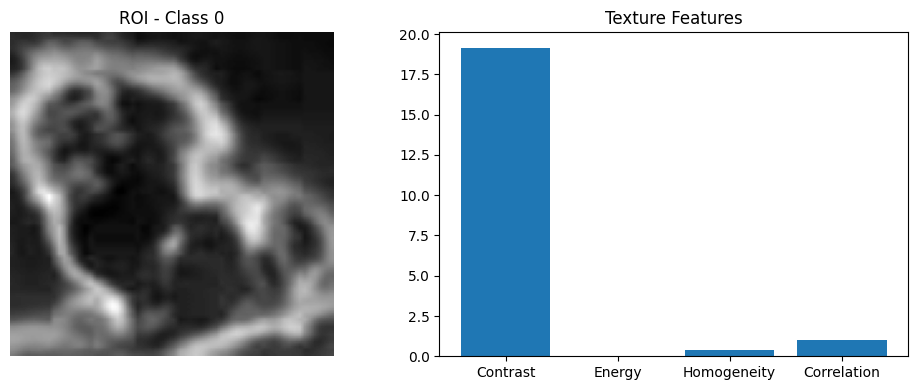

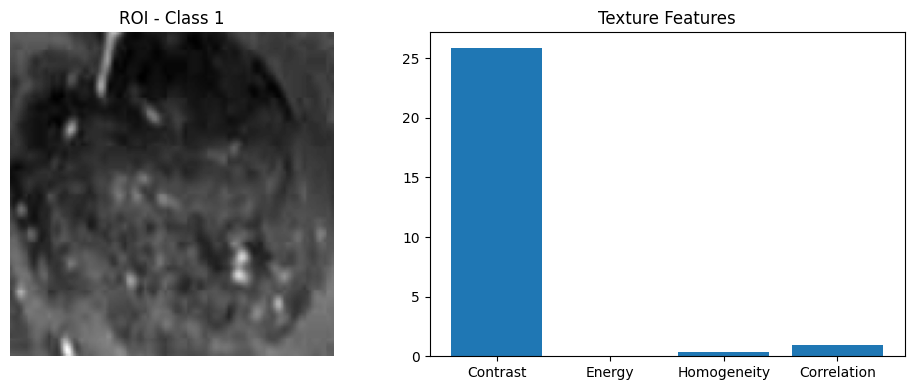

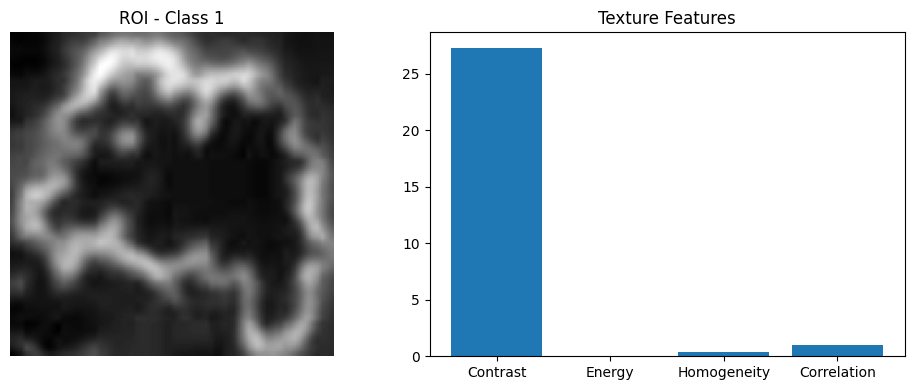

✅ Extracted 241 samples, feature length 8104
✅ Reduced feature dimensions: 8104 -> 200
Explained variance by PCA (first 2 PCs): [0.02695687 0.01996325]

📊 Top Results by Validation Accuracy
                                          params  train_acc   val_acc  \
0    {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}   0.970213  0.560166   
1  {'C': 0.5, 'gamma': 'scale', 'kernel': 'rbf'}   0.859574  0.518672   
2  {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}   0.519149  0.360996   

   overfit_gap  
0     0.410047  
1     0.340902  
2     0.158153  

✅ Best Model Results
Training Accuracy: 0.9702127659574468
Validation Accuracy: 0.5601659751037344
Confusion Matrix:
 [[105  49]
 [ 57  30]]


In [27]:
from cuml.preprocessing import StandardScaler
from cuml.decomposition import PCA

# ---------------------------
# Robust Preprocessing: Normalize + PCA
# ---------------------------
def preprocess_features_with_pca(X_train, X_val, n_components=200):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_val_pca = pca.transform(X_val_scaled)

    print(f"✅ Reduced feature dimensions: {X_train.shape[1]} -> {X_train_pca.shape[1]}")
    print(f"Explained variance by PCA (first 2 PCs): {pca.explained_variance_ratio_[:2]}")
    return X_train_pca, X_val_pca
def train_svm_robust(X_train, y_train, X_val, y_val):
    # More robust, lower C to avoid overfitting
    param_grid = {
        "C": [0.1, 0.5, 1],
        "kernel": ["rbf"],
        "gamma": ["scale"]
    }

    grid = list(ParameterGrid(param_grid))
    results = []

    for params in grid:
        svm = SVC(**params)
        svm.fit(X_train, y_train)

        y_train_pred = svm.predict(X_train)
        y_val_pred = svm.predict(X_val)

        train_acc = float(accuracy_score(cp.asnumpy(y_train), cp.asnumpy(y_train_pred)))
        val_acc = float(accuracy_score(cp.asnumpy(y_val), cp.asnumpy(y_val_pred)))

        results.append({
            "params": params,
            "train_acc": train_acc,
            "val_acc": val_acc,
            "overfit_gap": train_acc - val_acc
        })

    results_df = pd.DataFrame(results).sort_values(by="val_acc", ascending=False).reset_index(drop=True)
    best_params = results_df.iloc[0]["params"]

    print("\n📊 Top Results by Validation Accuracy")
    print(results_df.head(5))

    best_svm = SVC(**best_params)
    best_svm.fit(X_train, y_train)
    y_val_pred = best_svm.predict(X_val)

    metrics = {
        "train_accuracy": float(accuracy_score(cp.asnumpy(y_train), cp.asnumpy(best_svm.predict(X_train)))),
        "val_accuracy": float(accuracy_score(cp.asnumpy(y_val), cp.asnumpy(y_val_pred))),
        "confusion_matrix": confusion_matrix(cp.asnumpy(y_val), cp.asnumpy(y_val_pred)),
        "classification_report": classification_report(cp.asnumpy(y_val), cp.asnumpy(y_val_pred), output_dict=True)
    }

    return best_svm, metrics, y_val_pred
# Extract HOG + Texture
X_train, y_train = preprocess_and_extract_features(IMG_TRAIN, LBL_TRAIN, visualize_features=5)
X_val, y_val = preprocess_and_extract_features(IMG_VAL, LBL_VAL, visualize_features=5)

# Normalize + PCA
X_train_pca, X_val_pca = preprocess_features_with_pca(X_train, X_val, n_components=200)

# Train robust SVM
svm_model, metrics, y_val_pred = train_svm_robust(X_train_pca, y_train, X_val_pca, y_val)

# Results
print("\n✅ Best Model Results")
print("Training Accuracy:", metrics["train_accuracy"])
print("Validation Accuracy:", metrics["val_accuracy"])
print("Confusion Matrix:\n", metrics["confusion_matrix"])



📊 Extracting HOG + Texture Features ...
📂 Found 893 images in /kaggle/input/brain-tumor/images/train


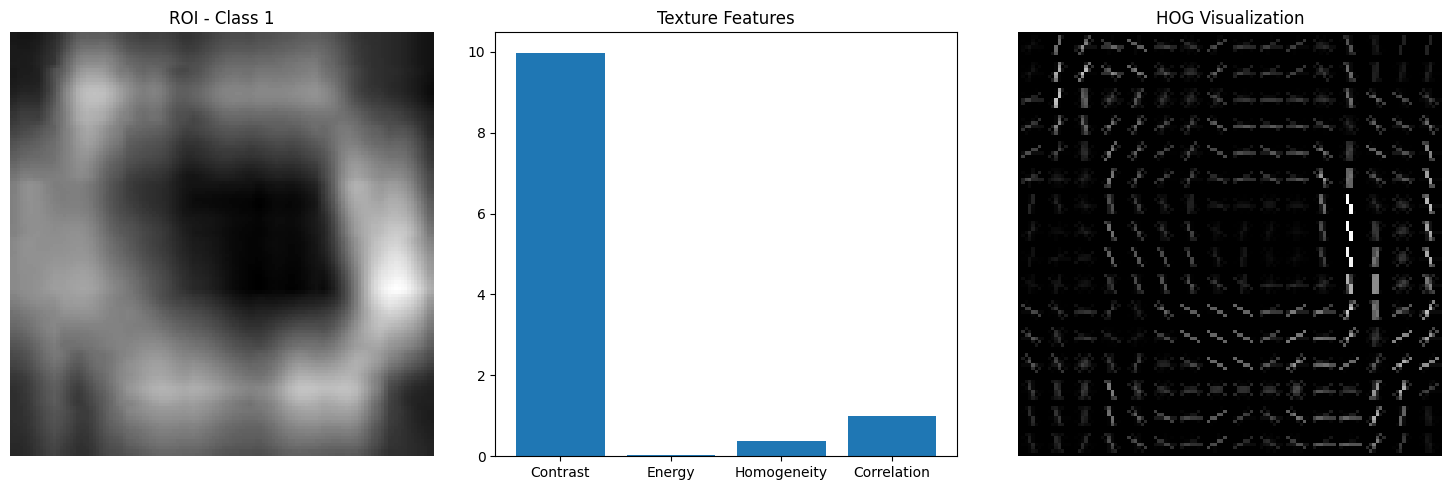

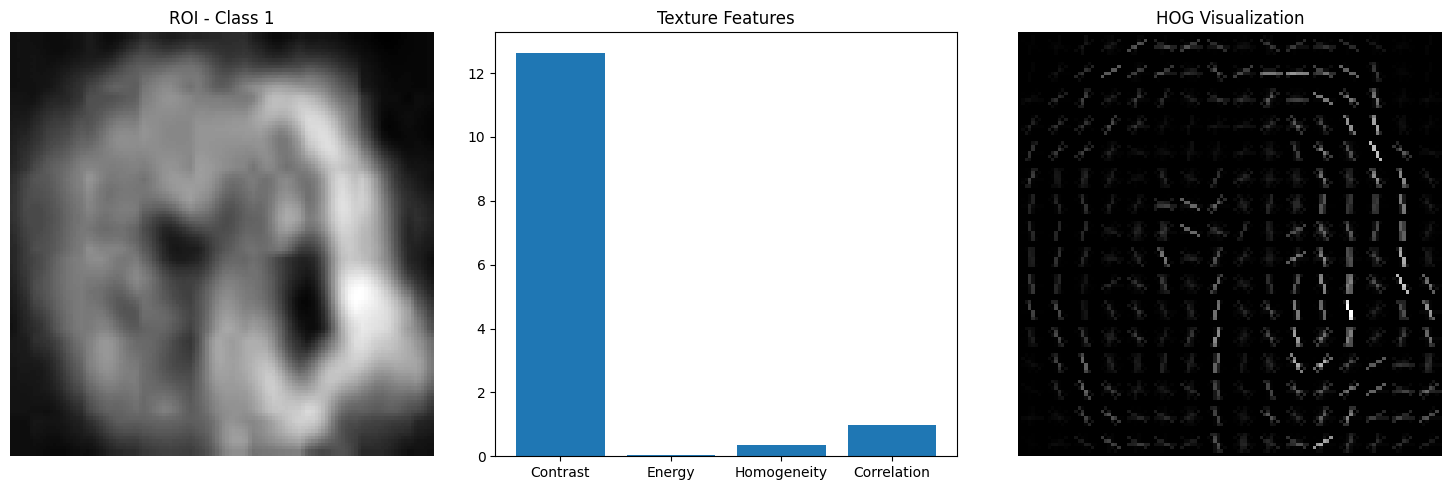

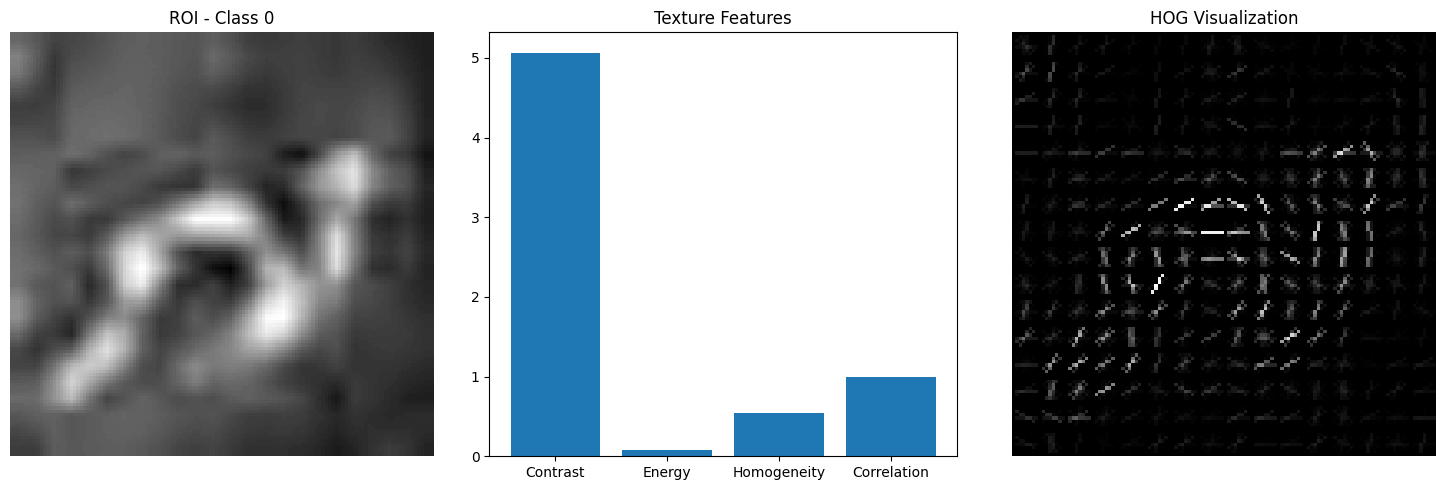

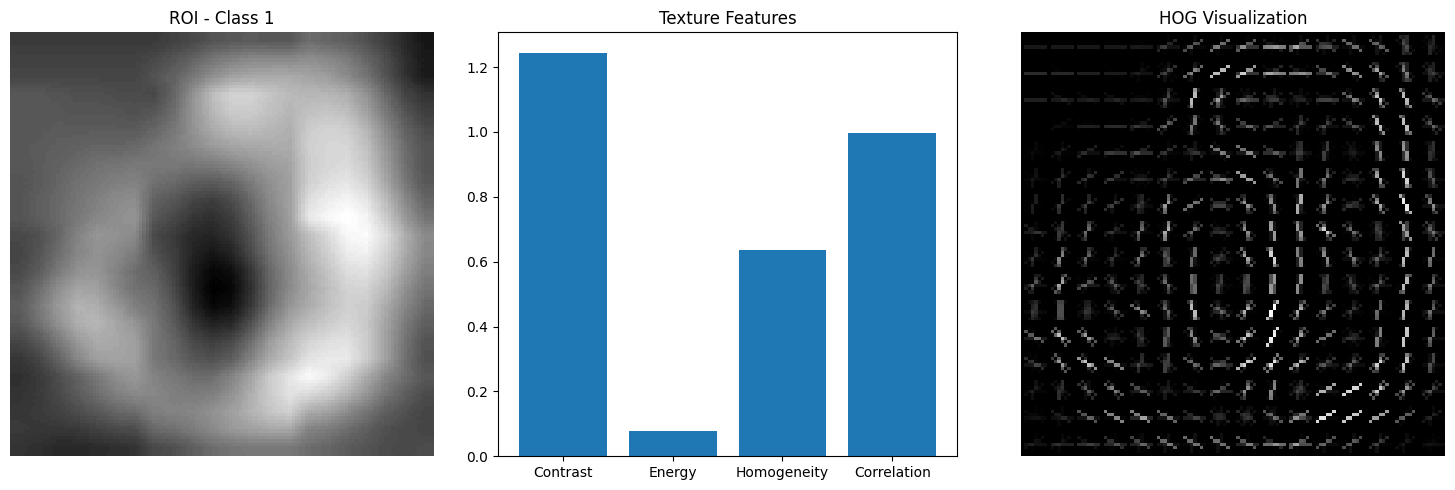

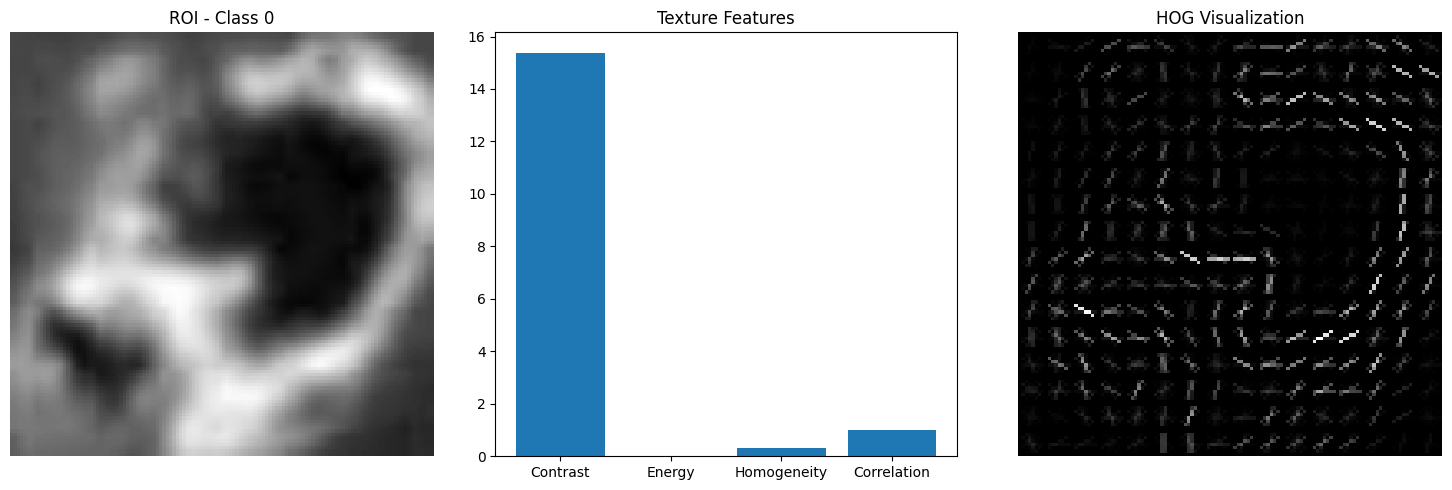

✅ Extracted 940 samples, feature length 204
📂 Found 223 images in /kaggle/input/brain-tumor/images/val


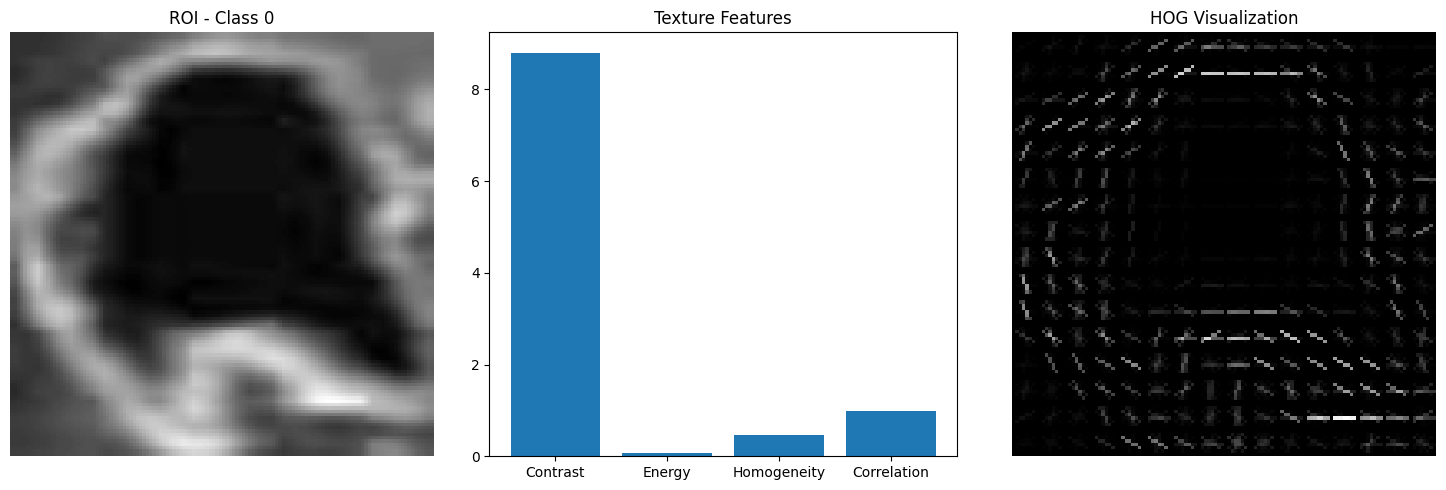

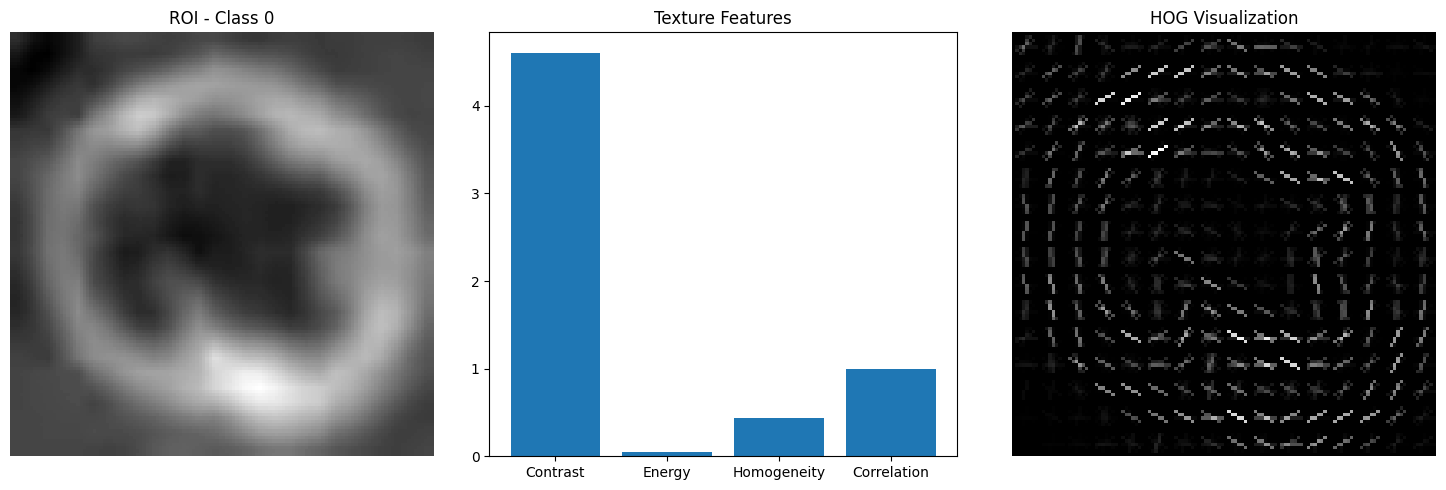

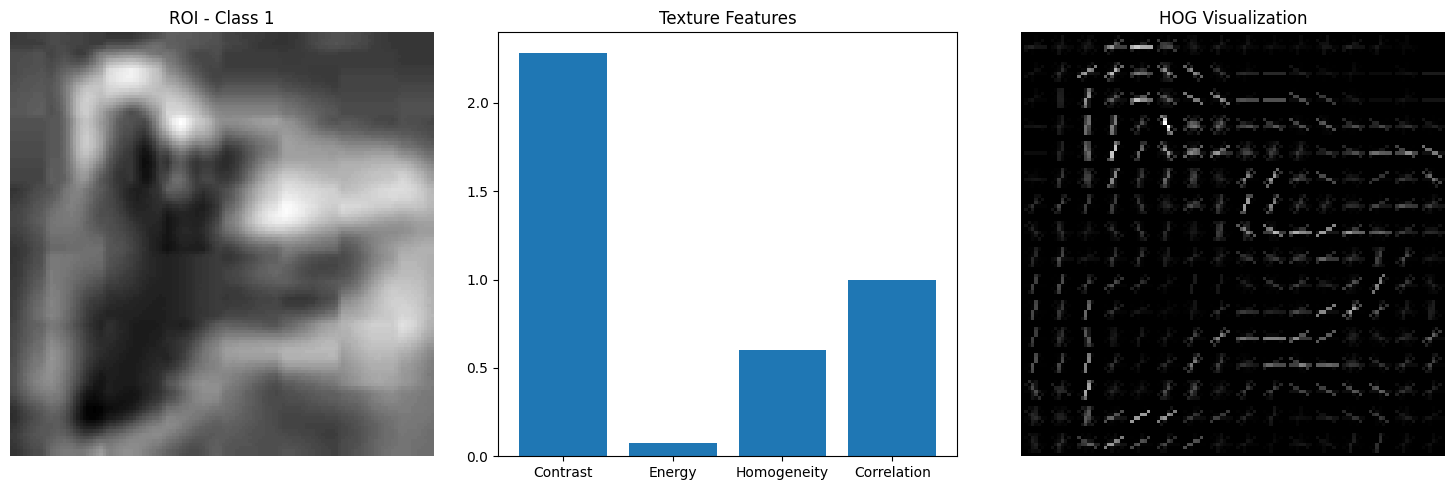

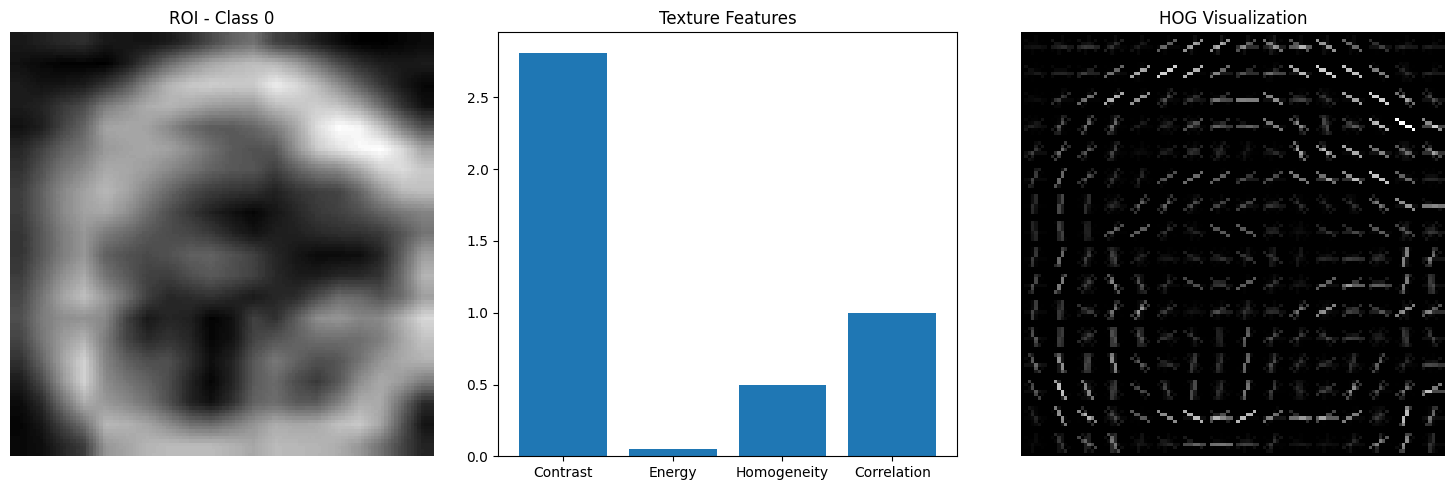

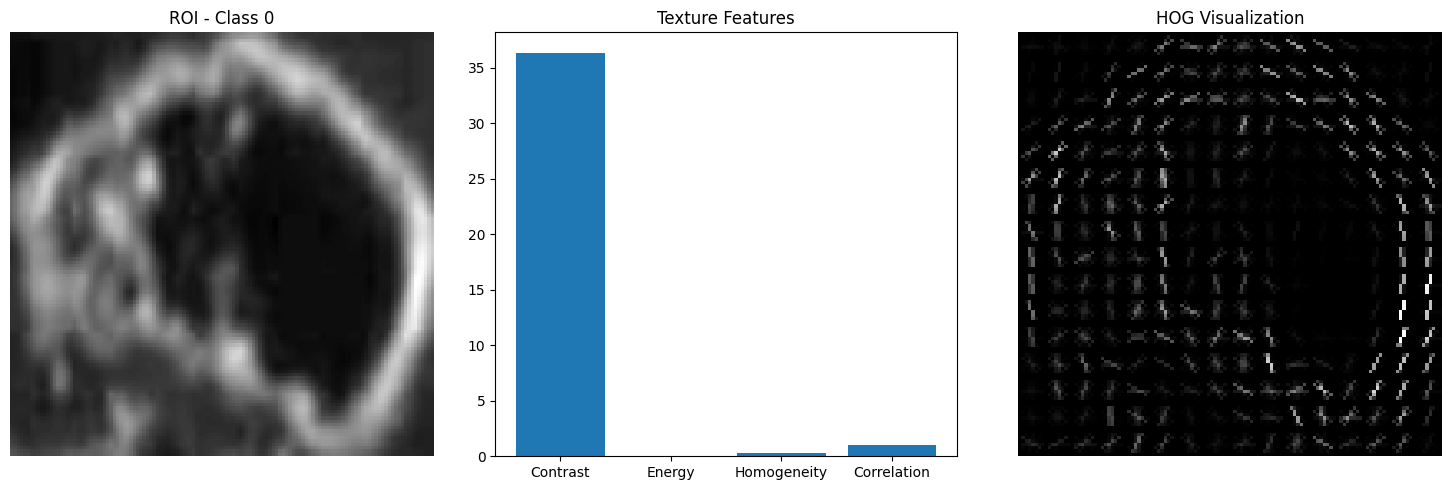

✅ Extracted 241 samples, feature length 204

🤖 Training GPU SVM with Grid Search...

📊 Top Results by Validation Accuracy
                                              params  train_acc   val_acc  \
0  {'C': 0.1, 'gamma': 0.004901960784313725, 'ker...   0.519149  0.360996   
1         {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}   0.519149  0.360996   
2          {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}   0.519149  0.360996   
3  {'C': 1, 'gamma': 0.004901960784313725, 'kerne...   1.000000  0.360996   
4           {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}   1.000000  0.360996   

   overfit_gap  
0     0.158153  
1     0.158153  
2     0.158153  
3     0.639004  
4     0.639004  

✅ Best Model Results
Training Accuracy: 0.5191489361702127
Validation Accuracy: 0.36099585062240663
Confusion Matrix:
 [[  0 154]
 [  0  87]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
import os
import cv2
import cupy as cp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from glob import glob
from cuml.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from skimage.feature import hog, graycomatrix, graycoprops

# ---------------------------
# ROI Cropper
# ---------------------------
def crop_roi_with_boxes(img_path, label_path, show_boxes=False):
    img_color = cv2.imread(img_path)
    if img_color is None:
        print(f"⚠️ Could not read {img_path}")
        return [], [], [], None
    img_gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)
    h, w = img_gray.shape[:2]

    rois, labels, boxes = [], [], []

    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f:
                cls, x, y, bw, bh = map(float, line.strip().split())
                x, y, bw, bh = int(x * w), int(y * h), int(bw * w), int(bh * h)
                x1, y1 = max(0, x - bw // 2), max(0, y - bh // 2)
                x2, y2 = min(w, x + bw // 2), min(h, y + bh // 2)
                roi = img_gray[y1:y2, x1:x2]
                if roi.size == 0:
                    continue
                rois.append(cv2.resize(roi, (128, 128)))
                labels.append(int(cls))
                boxes.append((x1, y1, x2, y2))
    else:
        rois.append(cv2.resize(img_gray, (128, 128)))
        labels.append(0)
        boxes.append((0, 0, w, h))

    return rois, labels, boxes, img_color

# ---------------------------
# Texture features (GLCM)
# ---------------------------
def extract_texture_features(roi):
    roi_uint8 = (roi * 255).astype(np.uint8)
    glcm = graycomatrix(roi_uint8, distances=[1], angles=[0],
                        levels=256, symmetric=True, normed=True)
    features = [
        graycoprops(glcm, 'contrast')[0, 0],
        graycoprops(glcm, 'energy')[0, 0],
        graycoprops(glcm, 'homogeneity')[0, 0],
        graycoprops(glcm, 'correlation')[0, 0]
    ]
    return np.array(features)

# ---------------------------
# Preprocess & Extract Features (HOG + Texture + Scaling + PCA)
# ---------------------------
def preprocess_and_extract_features(img_dir, lbl_dir, visualize_features=5, pca_components=200):
    X_features, y_labels = [], []
    img_paths = glob(os.path.join(img_dir, "*.jpg")) + glob(os.path.join(img_dir, "*.png"))
    print(f"📂 Found {len(img_paths)} images in {img_dir}")

    feature_vis_samples = random.sample(img_paths, min(visualize_features, len(img_paths)))

    for img_path in img_paths:
        lbl_path = os.path.join(lbl_dir, os.path.basename(img_path).replace(".jpg", ".txt").replace(".png", ".txt"))
        rois, labels, boxes, _ = crop_roi_with_boxes(img_path, lbl_path, show_boxes=False)

        for idx, (roi, label) in enumerate(zip(rois, labels)):
            roi_norm = roi.astype(np.float32) / 255.0

            # 🔹 HOG Features
            hog_feats = hog(roi_norm, pixels_per_cell=(8, 8),
                            cells_per_block=(2, 2), orientations=9,
                            block_norm='L2-Hys', feature_vector=True)

            # 🔹 Texture Features
            texture_feats = extract_texture_features(roi_norm)

            # 🔹 Scale separately
            hog_feats_scaled = (hog_feats - np.mean(hog_feats)) / (np.std(hog_feats)+1e-8)
            texture_feats_scaled = (texture_feats - np.mean(texture_feats)) / (np.std(texture_feats)+1e-8)

            # 🔹 Combine
            final_features = np.concatenate([hog_feats_scaled, texture_feats_scaled])

            X_features.append(final_features)
            y_labels.append(label)

            # ---------------------------
            # Visualize features for a few samples
            # ---------------------------
            if img_path in feature_vis_samples and idx == 0:
                # 1️⃣ ROI image
                plt.figure(figsize=(15,5))
                plt.subplot(1,3,1)
                plt.imshow(roi_norm, cmap='gray')
                plt.title(f"ROI - Class {label}")
                plt.axis('off')
            
                # 2️⃣ Texture features as bar graph
                plt.subplot(1,3,2)
                plt.bar(['Contrast','Energy','Homogeneity','Correlation'], texture_feats)
                plt.title("Texture Features")
            
                # 3️⃣ HOG visualization
                hog_image = hog(roi_norm, pixels_per_cell=(8, 8),
                                cells_per_block=(2, 2), orientations=9,
                                block_norm='L2-Hys', feature_vector=False, visualize=True)[1]
                plt.subplot(1,3,3)
                plt.imshow(hog_image, cmap='gray')
                plt.title("HOG Visualization")
                plt.axis('off')
            
                plt.tight_layout()
                plt.show()


    X_features = np.array(X_features)
    y_labels = np.array(y_labels)

    # 🔹 PCA on HOG features (first N dims of combined features)
    hog_len = len(hog_feats_scaled)
    X_hog = X_features[:,:hog_len]
    X_texture = X_features[:,hog_len:]

    pca = PCA(n_components=min(pca_components, hog_len))
    X_hog_pca = pca.fit_transform(X_hog)

    # Combine reduced HOG + Texture
    X_final = np.concatenate([X_hog_pca, X_texture], axis=1)
    print(f"✅ Extracted {X_final.shape[0]} samples, feature length {X_final.shape[1]}")
    return cp.asarray(X_final), cp.asarray(y_labels)

# ---------------------------
# Train GPU SVM with Grid Search
# ---------------------------
def train_svm_gridsearch(X_train, y_train, X_val, y_val):
    # Grid of hyperparameters
    gamma_auto = 1.0 / X_train.shape[1]  # approximate "scale"
    param_grid = {
        "C": [0.1, 1, 10],
        "kernel": ["rbf"],
        "gamma": [gamma_auto, 0.01, 0.1]  # all floats
    }

    from sklearn.model_selection import ParameterGrid
    results = []  # <-- define this BEFORE the loop!

    for params in ParameterGrid(param_grid):
        svm = SVC(**params)
        svm.fit(X_train, y_train)
        y_val_pred = svm.predict(X_val)

        train_acc = float(accuracy_score(cp.asnumpy(y_train), cp.asnumpy(svm.predict(X_train))))
        val_acc = float(accuracy_score(cp.asnumpy(y_val), cp.asnumpy(y_val_pred)))

        results.append({
            "params": params,
            "train_acc": train_acc,
            "val_acc": val_acc,
            "overfit_gap": train_acc - val_acc
        })

    # Sort results
    import pandas as pd
    results_df = pd.DataFrame(results).sort_values(by="val_acc", ascending=False).reset_index(drop=True)
    best_params = results_df.iloc[0]["params"]

    print("\n📊 Top Results by Validation Accuracy")
    print(results_df.head(5))

    # Train best SVM
    best_svm = SVC(**best_params)
    best_svm.fit(X_train, y_train)
    y_val_pred = best_svm.predict(X_val)

    metrics = {
        "train_accuracy": float(accuracy_score(cp.asnumpy(y_train), cp.asnumpy(best_svm.predict(X_train)))),
        "val_accuracy": float(accuracy_score(cp.asnumpy(y_val), cp.asnumpy(y_val_pred))),
        "confusion_matrix": confusion_matrix(cp.asnumpy(y_val), cp.asnumpy(y_val_pred)),
        "classification_report": classification_report(cp.asnumpy(y_val), cp.asnumpy(y_val_pred), output_dict=True)
    }

    return best_svm, metrics


# ---------------------------
# Main Execution
# ---------------------------
print("\n📊 Extracting HOG + Texture Features ...")
X_train, y_train = preprocess_and_extract_features(IMG_TRAIN, LBL_TRAIN, visualize_features=5, pca_components=200)
X_val, y_val = preprocess_and_extract_features(IMG_VAL, LBL_VAL, visualize_features=5, pca_components=200)

if X_train.size > 0 and X_val.size > 0:
    print("\n🤖 Training GPU SVM with Grid Search...")
    svm_model, metrics = train_svm_gridsearch(X_train, y_train, X_val, y_val)

    print("\n✅ Best Model Results")
    print("Training Accuracy:", metrics["train_accuracy"])
    print("Validation Accuracy:", metrics["val_accuracy"])
    print("Confusion Matrix:\n", metrics["confusion_matrix"])
else:
    print("❌ Not enough data to train model!")



📊 Extracting HOG + Texture Features ...
📂 Found 893 images in /kaggle/input/brain-tumor/images/train


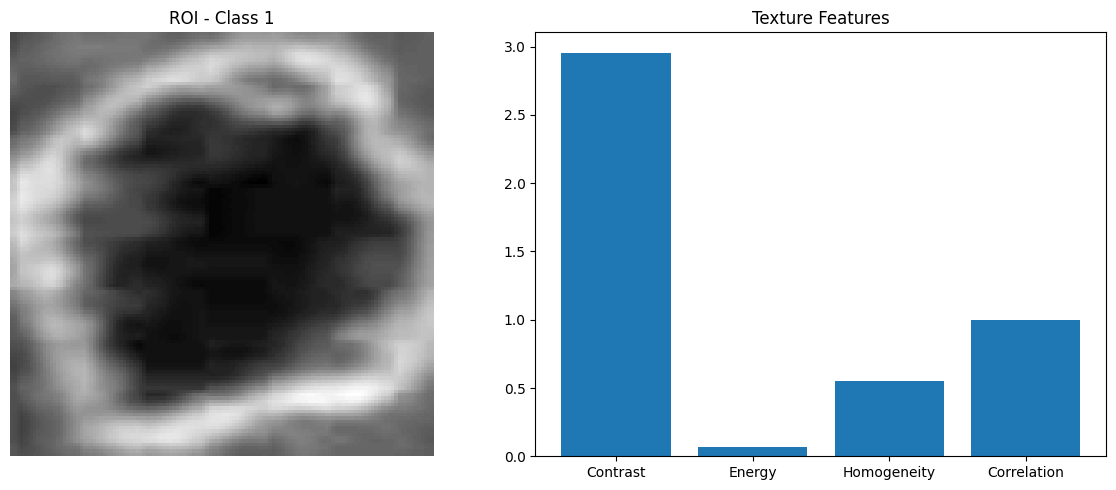

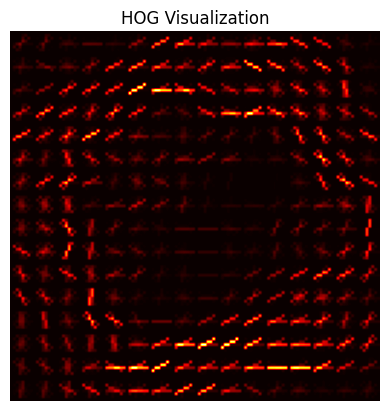

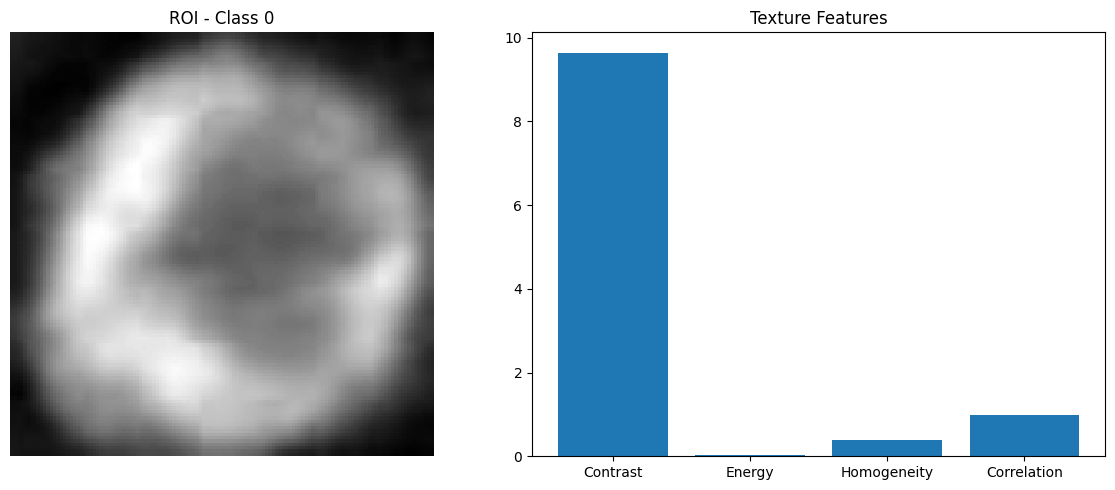

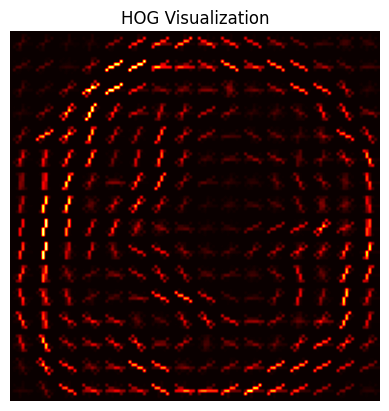

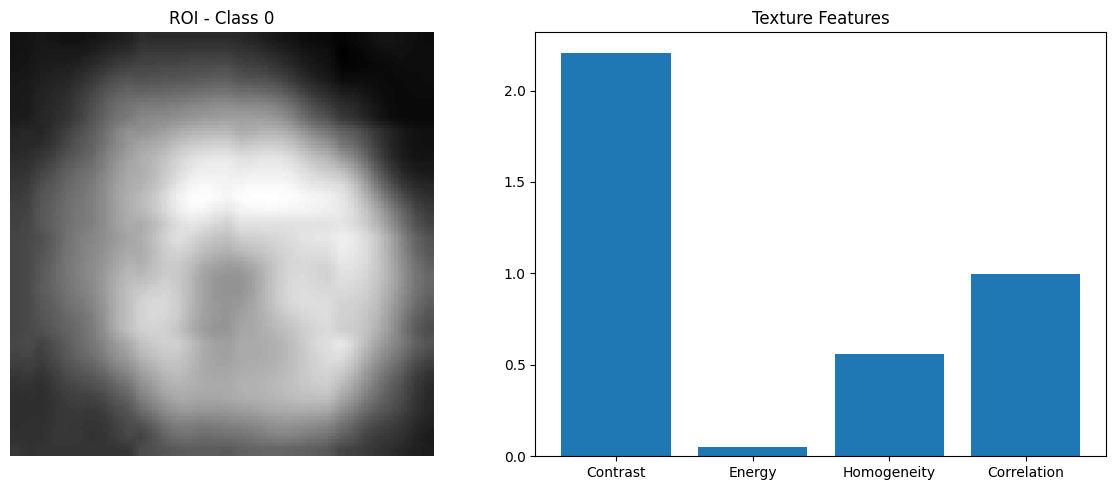

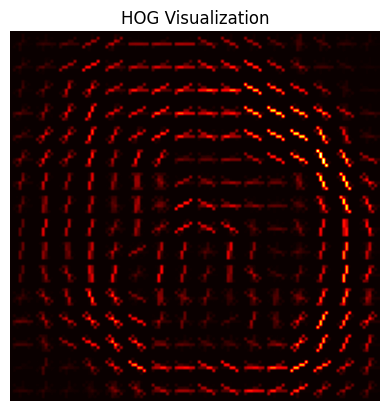

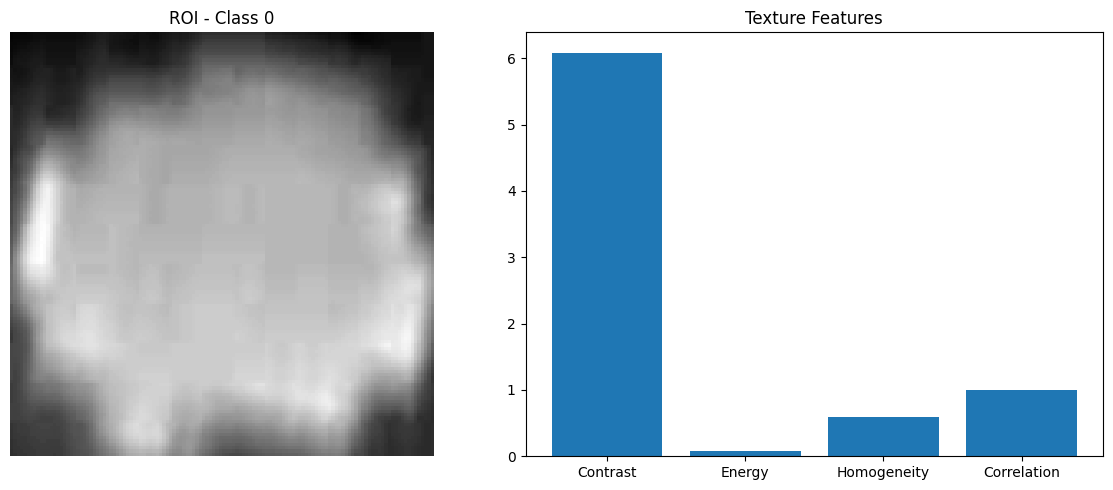

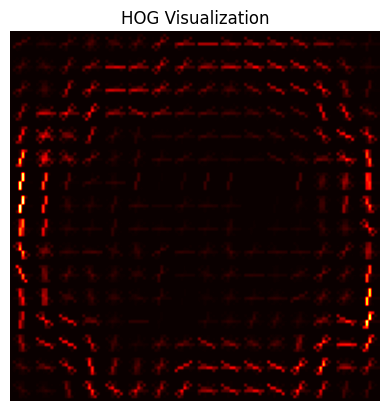

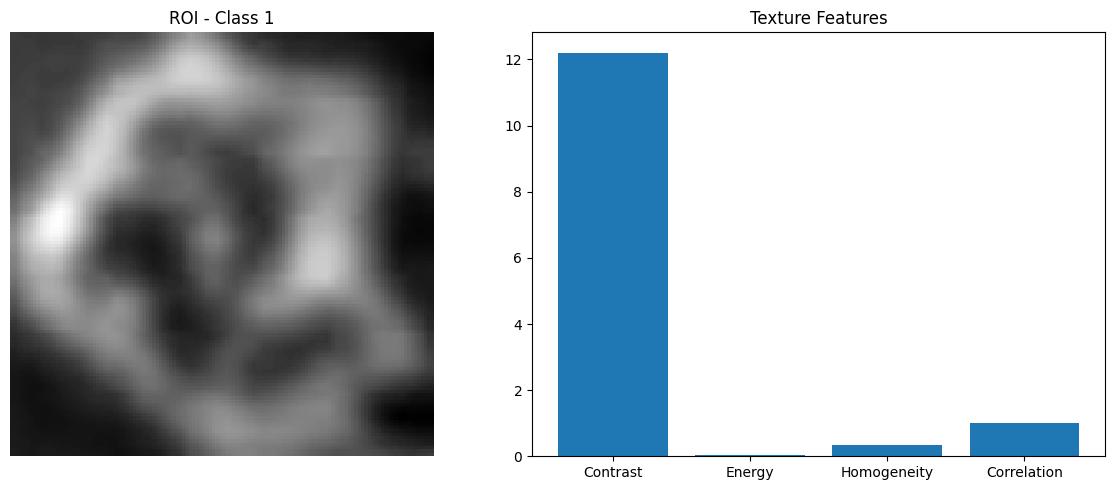

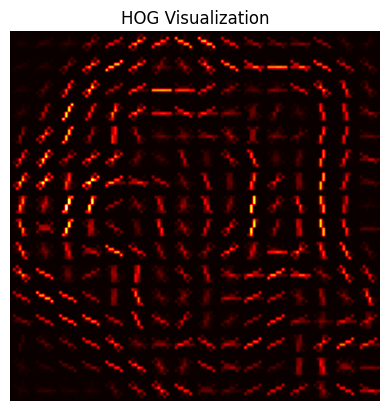

✅ Extracted 940 samples, feature length 8104
📂 Found 223 images in /kaggle/input/brain-tumor/images/val


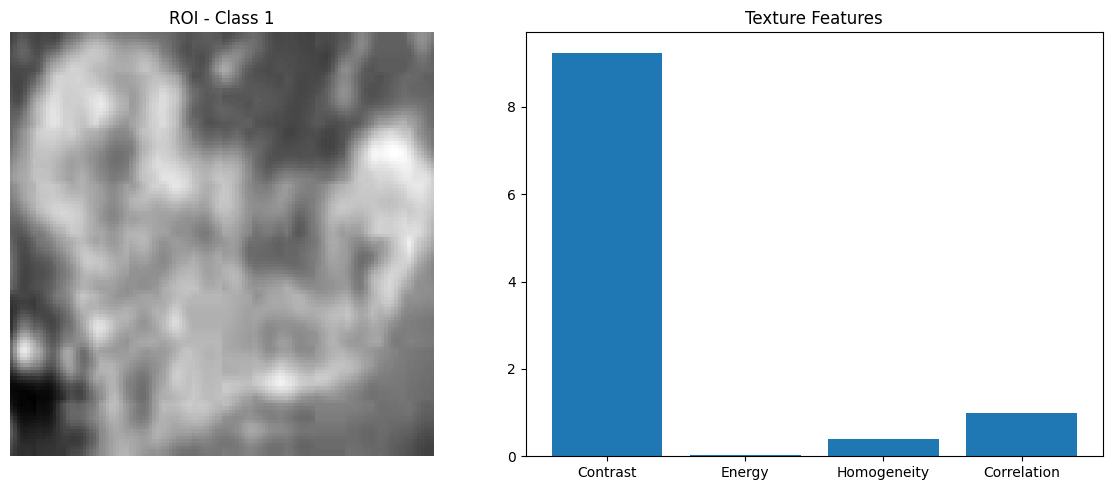

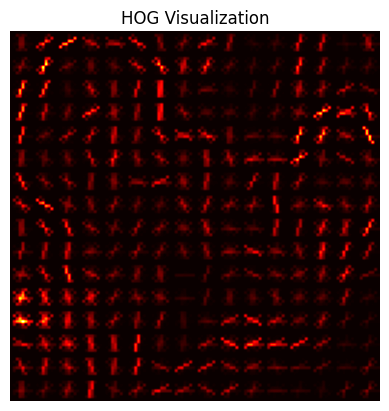

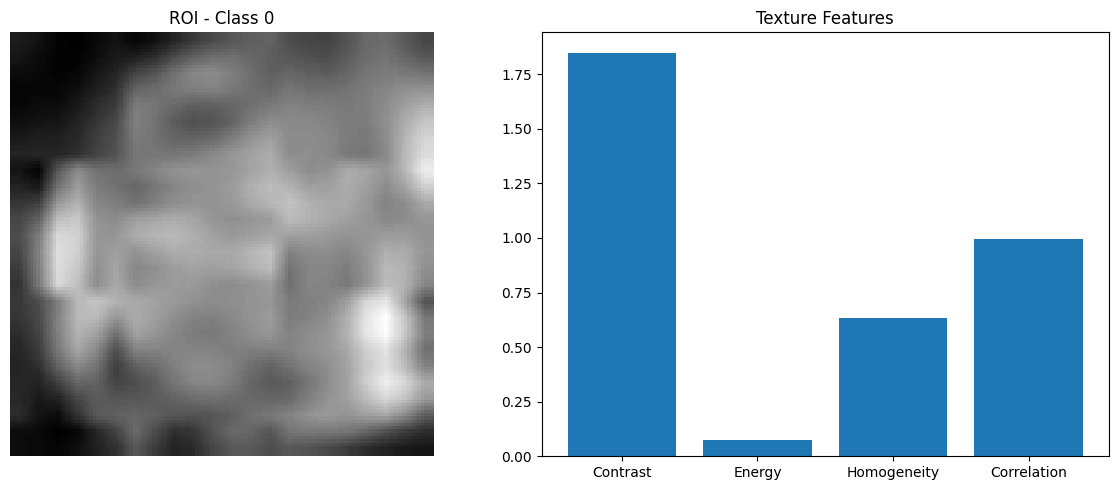

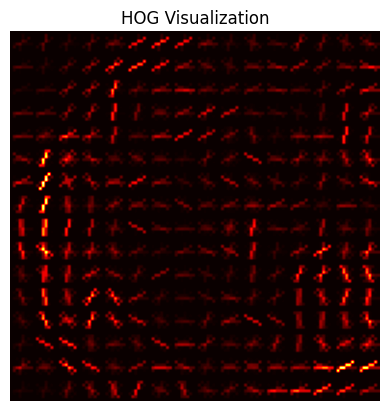

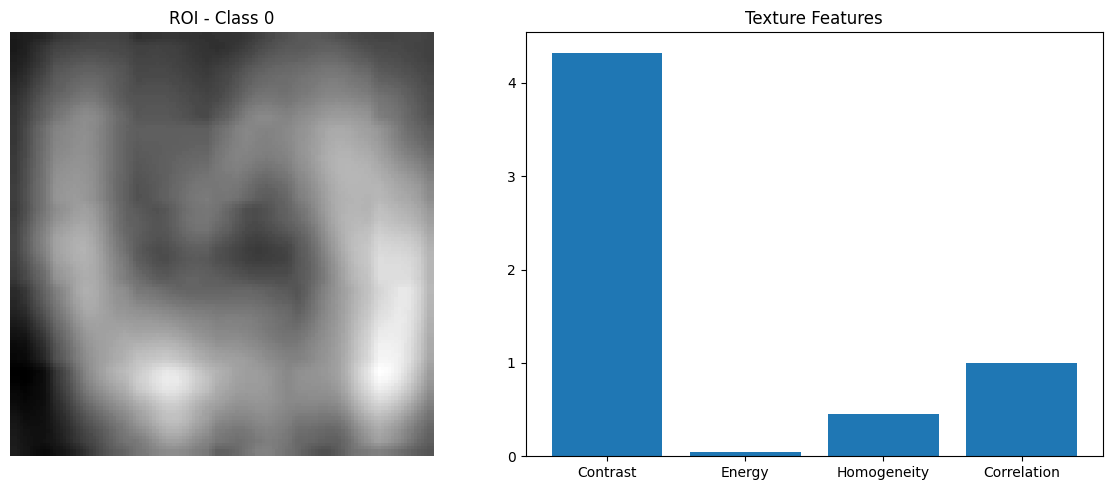

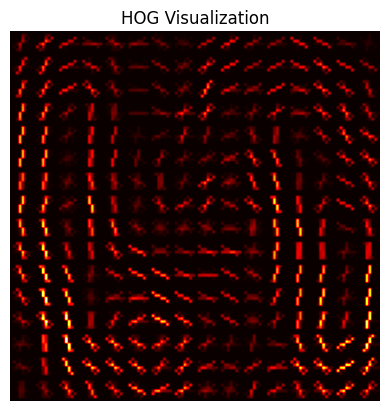

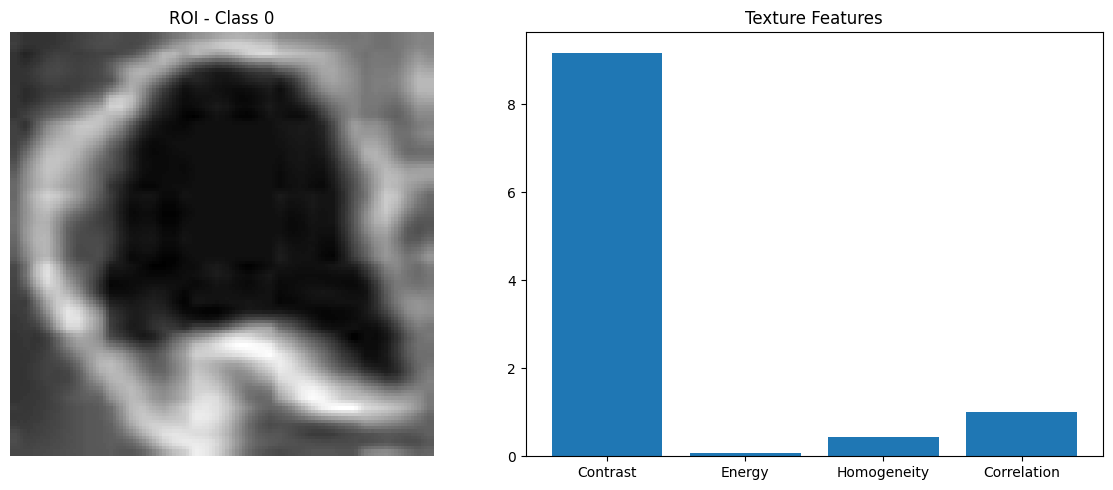

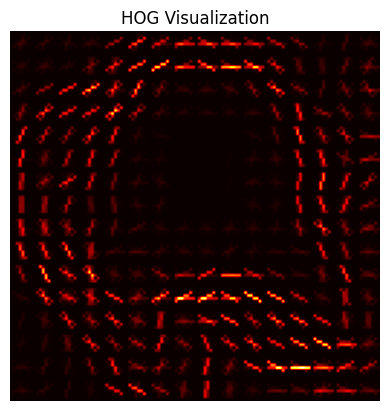

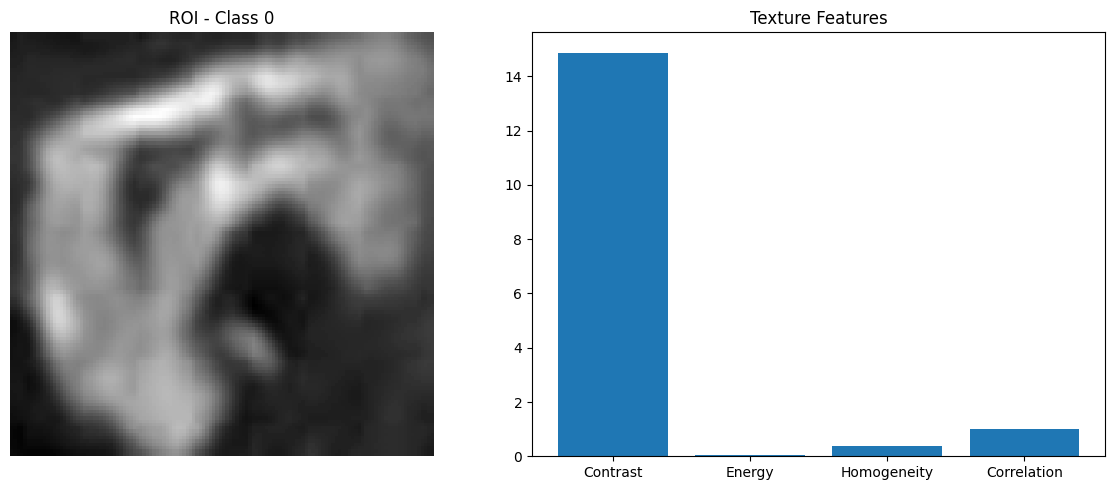

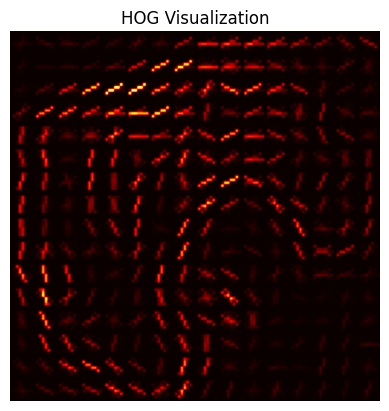

✅ Extracted 241 samples, feature length 8104

🤖 Training GPU Random Forest (No Regularization)...
[2025-09-11 13:22:47.095] [CUML] [info] Unused keyword parameter: min_rows_per_node during cuML estimator initialization

✅ Best Model Results
Training Accuracy: 1.0
Validation Accuracy: 0.5062240663900415
Confusion Matrix:
 [[63 91]
 [28 59]]


In [36]:
import os
import cv2
import cupy as cp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from glob import glob
from cuml.ensemble import RandomForestClassifier
from cuml.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from skimage.feature import hog, graycomatrix, graycoprops

# ---------------------------
# 0️⃣ Paths (Update these)
# ---------------------------


# ---------------------------
# ROI Cropper
# ---------------------------
def crop_roi_with_boxes(img_path, label_path, show_boxes=False):
    img_color = cv2.imread(img_path)
    if img_color is None:
        print(f"⚠️ Could not read {img_path}")
        return [], [], [], None
    img_gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)
    h, w = img_gray.shape[:2]

    rois, labels, boxes = [], [], []

    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f:
                cls, x, y, bw, bh = map(float, line.strip().split())
                x, y, bw, bh = int(x * w), int(y * h), int(bw * w), int(bh * h)
                x1, y1 = max(0, x - bw // 2), max(0, y - bh // 2)
                x2, y2 = min(w, x + bw // 2), min(h, y + bh // 2)
                roi = img_gray[y1:y2, x1:x2]
                if roi.size == 0:
                    continue
                rois.append(cv2.resize(roi, (128, 128)))
                labels.append(int(cls))
                boxes.append((x1, y1, x2, y2))
    else:
        rois.append(cv2.resize(img_gray, (128, 128)))
        labels.append(0)
        boxes.append((0, 0, w, h))

    return rois, labels, boxes, img_color

# ---------------------------
# Texture Features (GLCM)
# ---------------------------
def extract_texture_features(roi):
    roi_uint8 = (roi * 255).astype(np.uint8)
    glcm = graycomatrix(roi_uint8, distances=[1], angles=[0],
                        levels=256, symmetric=True, normed=True)
    features = [
        graycoprops(glcm, 'contrast')[0, 0],
        graycoprops(glcm, 'energy')[0, 0],
        graycoprops(glcm, 'homogeneity')[0, 0],
        graycoprops(glcm, 'correlation')[0, 0]
    ]
    return np.array(features)

# ---------------------------
# Feature Extraction: HOG + Texture
# ---------------------------
def preprocess_and_extract_features(img_dir, lbl_dir, visualize_features=5):
    X_features, y_labels = [], []
    img_paths = glob(os.path.join(img_dir, "*.jpg")) + glob(os.path.join(img_dir, "*.png"))
    print(f"📂 Found {len(img_paths)} images in {img_dir}")

    feature_vis_samples = random.sample(img_paths, min(visualize_features, len(img_paths)))

    for img_path in img_paths:
        lbl_path = os.path.join(lbl_dir, os.path.basename(img_path).replace(".jpg", ".txt").replace(".png", ".txt"))
        rois, labels, boxes, _ = crop_roi_with_boxes(img_path, lbl_path, show_boxes=False)

        for idx, (roi, label) in enumerate(zip(rois, labels)):
            roi_norm = roi.astype(np.float32) / 255.0

            # HOG features
            hog_feats = hog(roi_norm, pixels_per_cell=(8, 8),
                            cells_per_block=(2, 2), orientations=9,
                            block_norm='L2-Hys', feature_vector=True)

            # Texture features
            texture_feats = extract_texture_features(roi_norm)

            # Combine
            final_features = np.concatenate([hog_feats, texture_feats])

            X_features.append(final_features)
            y_labels.append(label)

            # Visualize features for a few samples
            if img_path in feature_vis_samples and idx == 0:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.imshow(roi_norm, cmap='gray')
                plt.title(f"ROI - Class {label}")
                plt.axis('off')

                plt.subplot(1, 2, 2)
                plt.bar(['Contrast','Energy','Homogeneity','Correlation'], texture_feats)
                plt.title("Texture Features")
                plt.tight_layout()
                plt.show()

                # Optional HOG visualization
                hog_image = hog(roi_norm, pixels_per_cell=(8, 8),
                                cells_per_block=(2, 2), orientations=9,
                                block_norm='L2-Hys', visualize=True)[1]
                plt.imshow(hog_image, cmap='hot')
                plt.title("HOG Visualization")
                plt.axis('off')
                plt.show()

    X_features = cp.asarray(X_features)
    y_labels = cp.asarray(y_labels)
    print(f"✅ Extracted {X_features.shape[0]} samples, feature length {X_features.shape[1]}")
    return X_features, y_labels

# ---------------------------
# GPU Random Forest (No Regularization)
# ---------------------------
def train_rf_gpu(X_train, y_train, X_val, y_val):
    rf = RandomForestClassifier(
        n_estimators=200,
        max_depth=1000,        # use a very high number instead of None
        min_rows_per_node=1,   # equivalent of min_samples_split=2
        random_state=42
    )
    rf.fit(X_train, y_train)
    y_train_pred = rf.predict(X_train)
    y_val_pred = rf.predict(X_val)

    metrics = {
        "train_accuracy": float(accuracy_score(cp.asnumpy(y_train), cp.asnumpy(y_train_pred))),
        "val_accuracy": float(accuracy_score(cp.asnumpy(y_val), cp.asnumpy(y_val_pred))),
        "confusion_matrix": confusion_matrix(cp.asnumpy(y_val), cp.asnumpy(y_val_pred)),
        "classification_report": classification_report(cp.asnumpy(y_val), cp.asnumpy(y_val_pred), output_dict=True)
    }
    return rf, metrics

# ---------------------------
# Main Execution
# ---------------------------
print("\n📊 Extracting HOG + Texture Features ...")
X_train, y_train = preprocess_and_extract_features(IMG_TRAIN, LBL_TRAIN, visualize_features=5)
X_val, y_val = preprocess_and_extract_features(IMG_VAL, LBL_VAL, visualize_features=5)

if X_train.size > 0 and X_val.size > 0:
    print("\n🤖 Training GPU Random Forest (No Regularization)...")
    rf_model, metrics = train_rf_gpu(X_train, y_train, X_val, y_val)

    print("\n✅ Best Model Results")
    print("Training Accuracy:", metrics["train_accuracy"])
    print("Validation Accuracy:", metrics["val_accuracy"])
    print("Confusion Matrix:\n", metrics["confusion_matrix"])
else:
    print("❌ Not enough data to train model!")



📊 Extracting HOG + Texture Features ...
📂 Found 893 images in /kaggle/input/brain-tumor/images/train


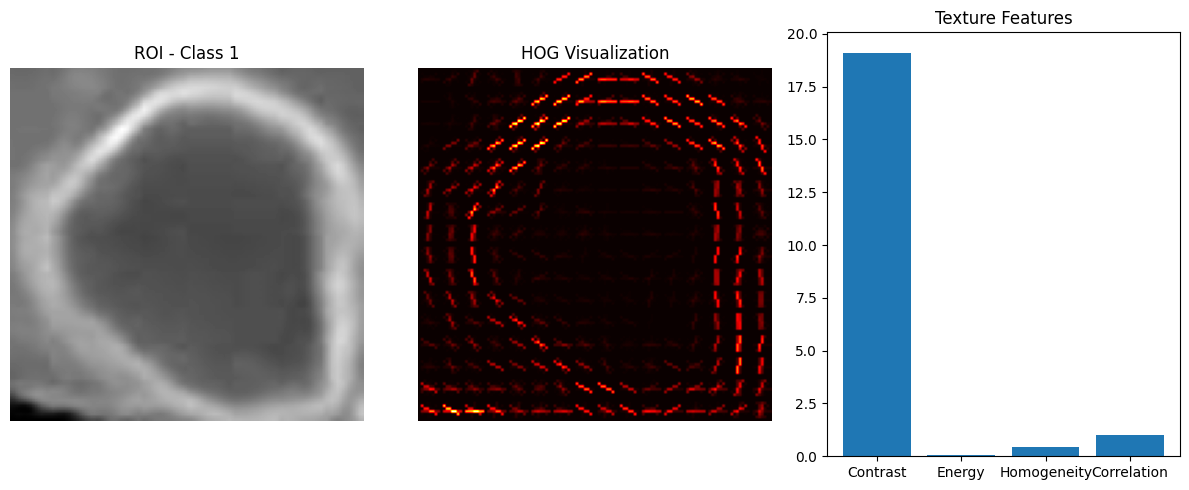

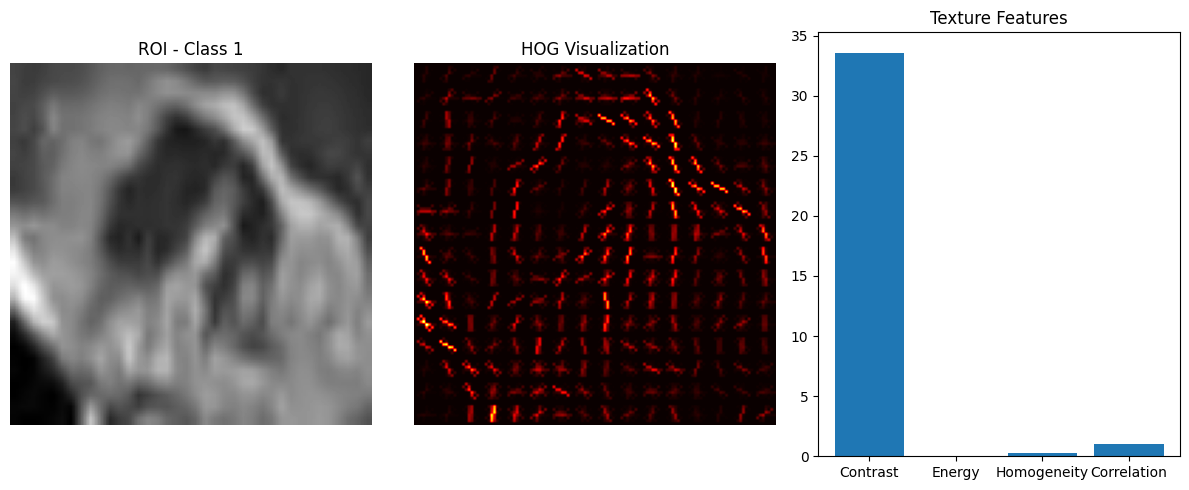

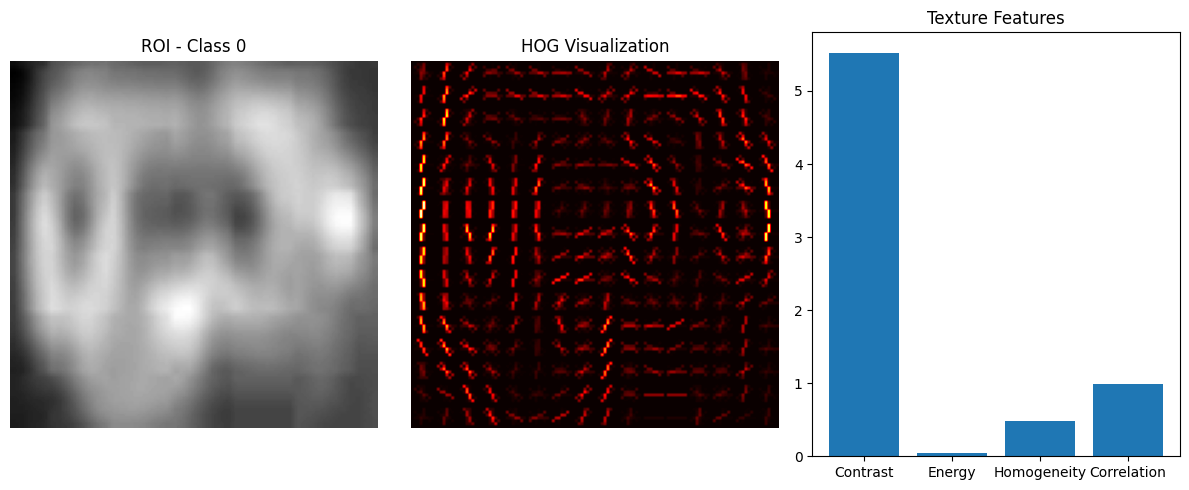

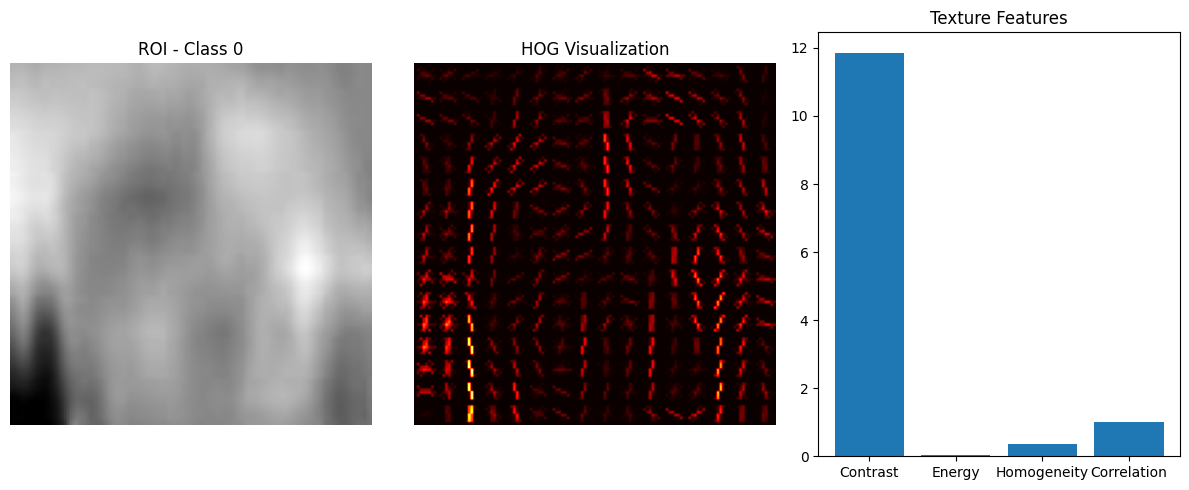

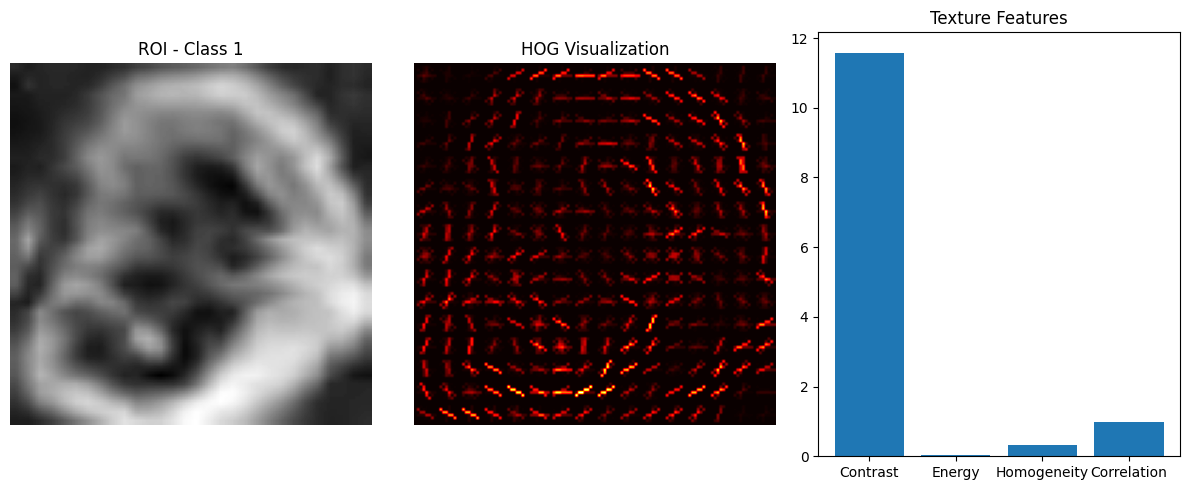

✅ Extracted 940 samples, feature length 8104
📂 Found 223 images in /kaggle/input/brain-tumor/images/val


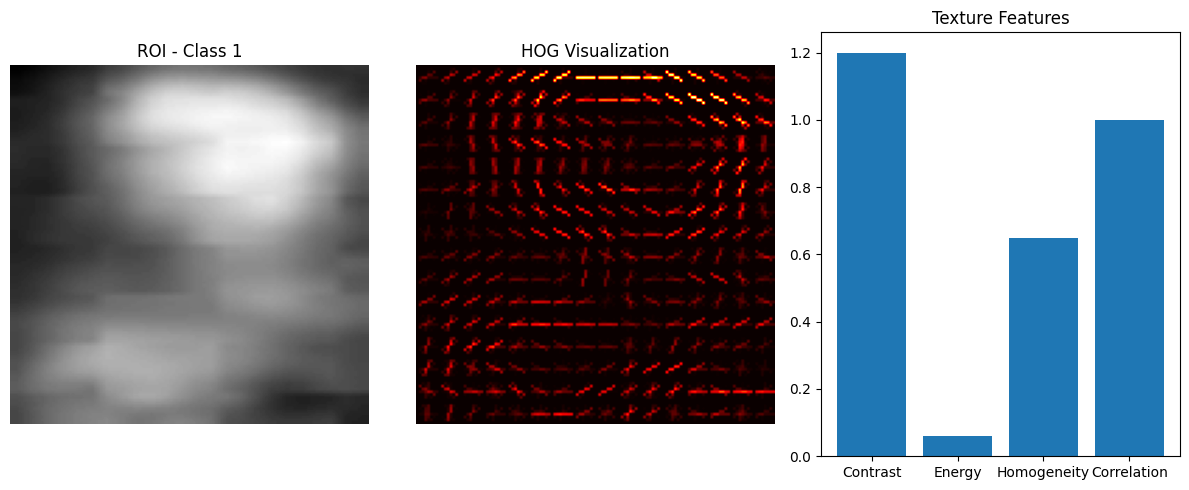

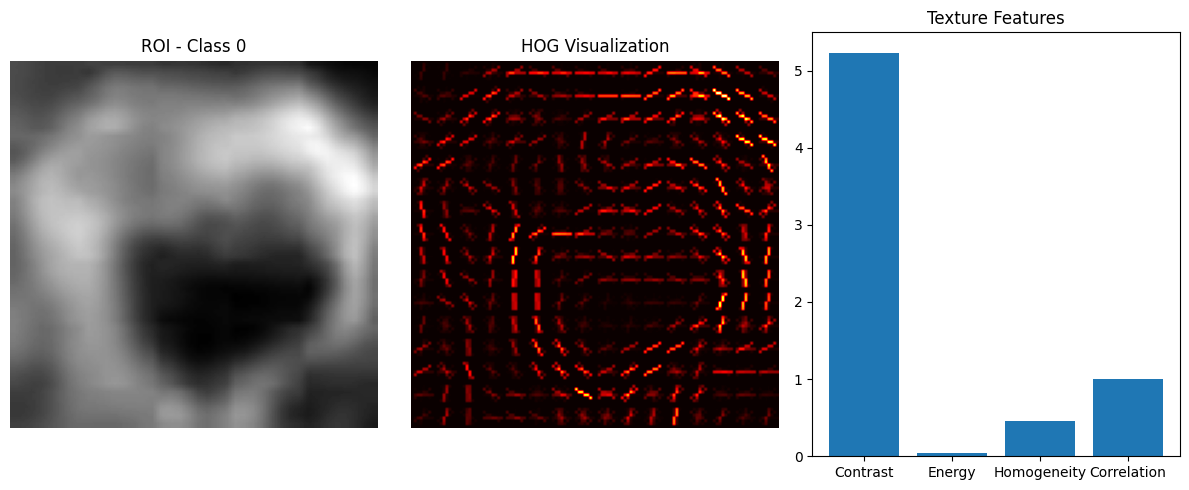

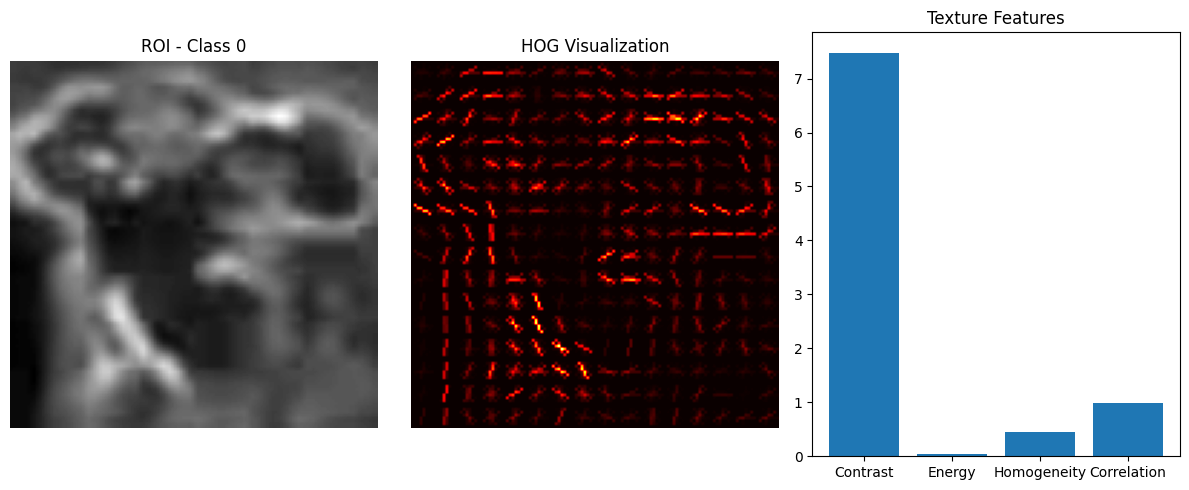

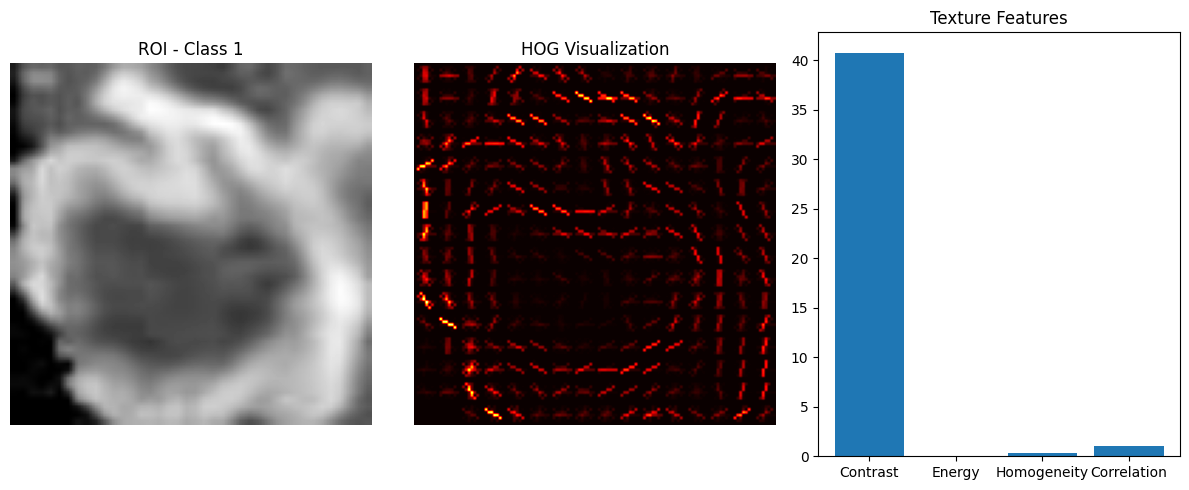

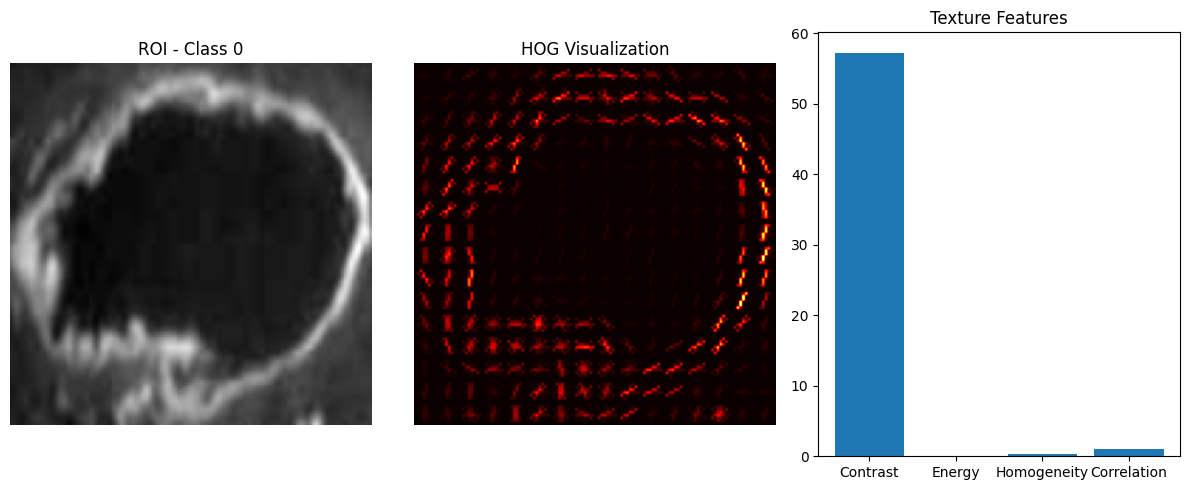

✅ Extracted 241 samples, feature length 8104

🤖 Training GPU Random Forest (Limited Depth)...
[2025-09-11 13:30:50.151] [CUML] [info] Unused keyword parameter: min_rows_per_node during cuML estimator initialization


/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:368: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)



✅ Best Model Results
Training Accuracy: 1.0
Validation Accuracy: 0.5062240663900415
Confusion Matrix:
 [[68 86]
 [33 54]]

🔍 Sample Predictions Visualization


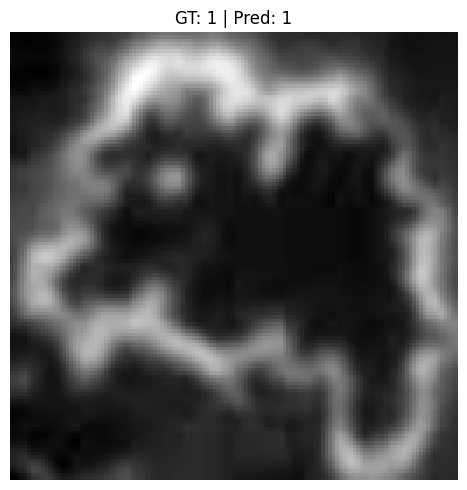

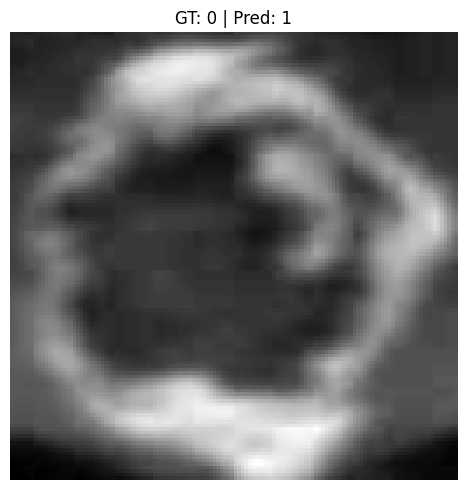

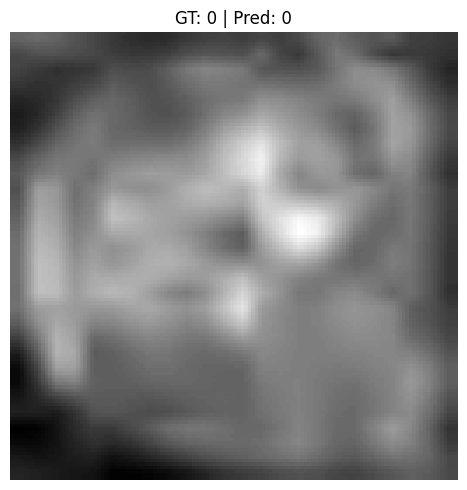

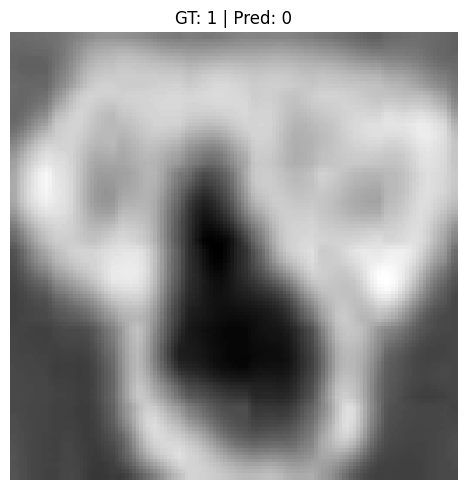

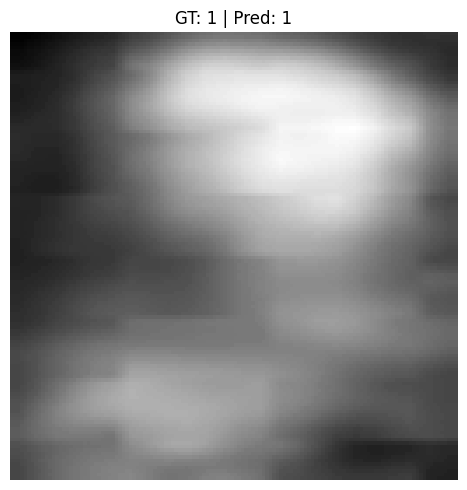

In [41]:
import os
import cv2
import cupy as cp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from glob import glob
from cuml.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from skimage.feature import hog, graycomatrix, graycoprops

# ---------------------------
# 0️⃣ Paths (Update these)
# ---------------------------
# ---------------------------
# ROI Cropper
# ---------------------------
def crop_roi_with_boxes(img_path, label_path, show_boxes=False):
    img_color = cv2.imread(img_path)
    if img_color is None:
        print(f"⚠️ Could not read {img_path}")
        return [], [], [], None
    img_gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)
    h, w = img_gray.shape[:2]

    rois, labels, boxes = [], [], []

    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f:
                cls, x, y, bw, bh = map(float, line.strip().split())
                x, y, bw, bh = int(x * w), int(y * h), int(bw * w), int(bh * h)
                x1, y1 = max(0, x - bw // 2), max(0, y - bh // 2)
                x2, y2 = min(w, x + bw // 2), min(h, y + bh // 2)
                roi = img_gray[y1:y2, x1:x2]
                if roi.size == 0:
                    continue
                rois.append(cv2.resize(roi, (128, 128)))
                labels.append(int(cls))
                boxes.append((x1, y1, x2, y2))
    else:
        rois.append(cv2.resize(img_gray, (128, 128)))
        labels.append(0)
        boxes.append((0, 0, w, h))

    return rois, labels, boxes, img_color

# ---------------------------
# Texture Features (GLCM)
# ---------------------------
def extract_texture_features(roi):
    roi_uint8 = (roi * 255).astype(np.uint8)
    glcm = graycomatrix(roi_uint8, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    features = [
        graycoprops(glcm, 'contrast')[0, 0],
        graycoprops(glcm, 'energy')[0, 0],
        graycoprops(glcm, 'homogeneity')[0, 0],
        graycoprops(glcm, 'correlation')[0, 0]
    ]
    return np.array(features)

# ---------------------------
# Feature Extraction: HOG + Texture
# ---------------------------
def preprocess_and_extract_features(img_dir, lbl_dir, visualize_features=5):
    X_features, y_labels = [], []
    img_paths = glob(os.path.join(img_dir, "*.jpg")) + glob(os.path.join(img_dir, "*.png"))
    print(f"📂 Found {len(img_paths)} images in {img_dir}")

    feature_vis_samples = random.sample(img_paths, min(visualize_features, len(img_paths)))

    for img_path in img_paths:
        lbl_path = os.path.join(lbl_dir, os.path.basename(img_path).replace(".jpg", ".txt").replace(".png", ".txt"))
        rois, labels, boxes, _ = crop_roi_with_boxes(img_path, lbl_path, show_boxes=False)

        for idx, (roi, label) in enumerate(zip(rois, labels)):
            roi_norm = roi.astype(np.float32) / 255.0

            # HOG features + HOG image
            hog_feats, hog_image = hog(roi_norm, pixels_per_cell=(8, 8),
                                       cells_per_block=(2, 2), orientations=9,
                                       block_norm='L2-Hys', feature_vector=True,
                                       visualize=True)

            # Texture features
            texture_feats = extract_texture_features(roi_norm)

            # Combine
            final_features = np.concatenate([hog_feats, texture_feats])
            X_features.append(final_features)
            y_labels.append(label)

            # Visualize a few samples
            if img_path in feature_vis_samples and idx == 0:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 3, 1)
                plt.imshow(roi_norm, cmap='gray')
                plt.title(f"ROI - Class {label}")
                plt.axis('off')

                plt.subplot(1, 3, 2)
                plt.imshow(hog_image, cmap='hot')
                plt.title("HOG Visualization")
                plt.axis('off')

                plt.subplot(1, 3, 3)
                plt.bar(['Contrast','Energy','Homogeneity','Correlation'], texture_feats)
                plt.title("Texture Features")
                plt.tight_layout()
                plt.show()

    X_features = cp.asarray(X_features)
    y_labels = cp.asarray(y_labels)
    print(f"✅ Extracted {X_features.shape[0]} samples, feature length {X_features.shape[1]}")
    return X_features, y_labels

# ---------------------------
# GPU Random Forest (Limited Depth to Reduce Overfitting)
# ---------------------------
def train_rf_gpu(X_train, y_train, X_val, y_val):
    rf = RandomForestClassifier(
        n_estimators=150,
        max_depth=25,          # limit depth
        max_features=0.8,      # only subset of features at each split
        min_rows_per_node=2,   # minimum samples per node
        random_state=42
    )
    rf.fit(X_train, y_train)

    y_train_pred = rf.predict(X_train)
    y_val_pred = rf.predict(X_val)

    metrics = {
        "train_accuracy": float(accuracy_score(cp.asnumpy(y_train), cp.asnumpy(y_train_pred))),
        "val_accuracy": float(accuracy_score(cp.asnumpy(y_val), cp.asnumpy(y_val_pred))),
        "confusion_matrix": confusion_matrix(cp.asnumpy(y_val), cp.asnumpy(y_val_pred)),
        "classification_report": classification_report(cp.asnumpy(y_val), cp.asnumpy(y_val_pred), output_dict=True)
    }
    return rf, metrics, y_val_pred

# ---------------------------
# Visualize Sample Predictions
# ---------------------------
def visualize_predictions(rf_model, img_dir, lbl_dir, num_samples=5):
    img_paths = glob(os.path.join(img_dir, "*.jpg")) + glob(os.path.join(img_dir, "*.png"))
    samples = random.sample(img_paths, min(num_samples, len(img_paths)))

    for img_path in samples:
        lbl_path = os.path.join(lbl_dir, os.path.basename(img_path).replace(".jpg", ".txt").replace(".png", ".txt"))
        rois, labels, boxes, img_color = crop_roi_with_boxes(img_path, lbl_path)

        if len(rois) == 0:
            continue

        plt.figure(figsize=(15, 5))
        for idx, (roi, label) in enumerate(zip(rois, labels)):
            roi_norm = roi.astype(np.float32) / 255.0
            hog_feats = hog(roi_norm, pixels_per_cell=(8, 8), cells_per_block=(2, 2),
                            orientations=9, block_norm='L2-Hys', feature_vector=True)
            texture_feats = extract_texture_features(roi_norm)
            features = cp.asarray(np.concatenate([hog_feats, texture_feats]))
            pred = int(rf_model.predict(features.reshape(1, -1))[0])

            plt.subplot(1, len(rois), idx + 1)
            plt.imshow(roi, cmap='gray')
            plt.title(f"GT: {label} | Pred: {pred}")
            plt.axis('off')
        plt.tight_layout()
        plt.show()

# ---------------------------
# Main Execution
# ---------------------------
print("\n📊 Extracting HOG + Texture Features ...")
X_train, y_train = preprocess_and_extract_features(IMG_TRAIN, LBL_TRAIN, visualize_features=5)
X_val, y_val = preprocess_and_extract_features(IMG_VAL, LBL_VAL, visualize_features=5)

if X_train.size > 0 and X_val.size > 0:
    print("\n🤖 Training GPU Random Forest (Limited Depth)...")
    rf_model, metrics, y_val_pred = train_rf_gpu(X_train, y_train, X_val, y_val)

    print("\n✅ Best Model Results")
    print("Training Accuracy:", metrics["train_accuracy"])
    print("Validation Accuracy:", metrics["val_accuracy"])
    print("Confusion Matrix:\n", metrics["confusion_matrix"])

    # Visualize some test predictions
    print("\n🔍 Sample Predictions Visualization")
    visualize_predictions(rf_model, IMG_VAL, LBL_VAL, num_samples=5)
else:
    print("❌ Not enough data to train model!")
